# Import libraries

In [160]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [161]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import os
from scipy.stats import mode

import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output
from concurrent.futures import ThreadPoolExecutor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

# Load the dataset

In [162]:
import pandas as pd
import os

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

# Merge train and test datasets with additional features (if any)
# Since there's no time-series data, this step is commented out.
# Ensure train and test already have all required features.
# train = pd.merge(train, additional_features_df, how="left", on='id')
# test = pd.merge(test, additional_features_df, how="left", on='id')

# Drop the 'id' column
if 'id' in train.columns:
    train = train.drop('id', axis=1)
if 'id' in test.columns:
    test = test.drop('id', axis=1)

# Define the feature columns
featuresCols = [
    'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
    'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
    'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
    'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
    'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
    'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
    'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
    'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
    'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
    'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
    'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
    'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
    'PreInt_EduHx-computerinternet_hoursday', 'sii'
]

# Select only the specified feature columns
train = train[featuresCols]
train = train.dropna(subset=['sii'])  # Ensure 'sii' column has no missing values

# Handle categorical columns
cat_c = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season',
    'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

def update(df):
    for c in cat_c:
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)

# Create mappings for categorical columns
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping_train = create_mapping(col, train)
    train[col] = train[col].replace(mapping_train).astype(int)
    test[col] = test[col].replace(mapping_train).astype(int)

# Output the shapes of the train and test datasets
print(f'Train Shape : {train.shape} || Test Shape : {test.shape}')


Train Shape : (2736, 59) || Test Shape : (20, 58)


In [163]:
%%time

train.head()

CPU times: total: 0 ns
Wall time: 0 ns


,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0,2.0
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0,0.0
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0,0.0
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,3,2.451,2,31.0,45.0,2,0.0,1.0
5,3,13,1,0,50.0,1,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,0,NaN,NaN,NaN,1,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,3,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,0,NaN,4,4.110,2,40.0,56.0,3,0.0,1.0


In [164]:
train.shape

(2736, 59)

In [165]:
train.isnull().sum()

Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                                  0
CGAS-CGAS_Score                            394
Physical-Season                              0
Physical-BMI                               209
Physical-Height                            206
Physical-Weight                            164
Physical-Waist_Circumference              2253
Physical-Diastolic_BP                      258
Physical-HeartRate                         250
Physical-Systolic_BP                       258
Fitness_Endurance-Season                     0
Fitness_Endurance-Max_Stage               2005
Fitness_Endurance-Time_Mins               2008
Fitness_Endurance-Time_Sec                2008
FGC-Season                                   0
FGC-FGC_CU                                 817
FGC-FGC_CU_Zone                            852
FGC-FGC_GSND                              1864
FGC-FGC_GSND_

In [166]:
train.describe()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
count,2736.000000,2736.000000,2736.000000,2736.000000,2342.000000,2736.000000,2527.000000,2530.000000,2572.000000,483.000000,2478.000000,2486.000000,2478.000000,2736.000000,731.000000,728.000000,728.000000,2736.000000,1919.000000,1884.000000,872.000000,864.000000,871.000000,864.000000,1909.000000,1875.000000,1911.000000,1877.000000,1913.000000,1879.000000,1919.000000,1885.000000,2736.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,1813.000000,2736.000000,363.000000,2736.000000,1440.000000,2736.000000,2527.000000,2525.000000,2736.000000,2654.000000,2736.000000
mean,1.536550,10.238670,0.364401,2.155336,65.159266,2.054825,19.125667,55.897051,87.839592,26.625259,69.755044,81.823411,117.127926,1.185307,5.001368,7.394231,27.656593,1.643275,11.912976,0.524947,22.077970,1.820602,23.083639,1.887731,5.782609,0.347200,8.767975,0.636654,8.877888,0.634380,9.119567,0.772944,2.010965,2.671263,6.954484,19.232347,1236.604226,2069.411478,20.781963,73.977613,14.992021,4.240327,15.827994,1.733591,33.134537,20.061121,67.023130,34.372294,53.916500,0.330044,2.185758,1.376827,2.590608,2.361842,40.977839,57.647525,1.540205,1.015072,0.580409
std,1.131297,3.427982,0.481350,1.441990,11.811050,1.560923,4.909305,7.394938,43.353079,5.230213,13.790203,13.769816,17.221707,1.494053,2.016711,3.180463,17.756420,1.204780,11.979877,0.499510,10.484763,0.613854,10.517376,0.616601,7.441061,0.476207,3.289944,0.481091,3.320215,0.481732,2.954478,0.419040,1.295707,1.030997,97.022087,4.921900,1960.147933,2966.453800,76.697505,208.781862,6.012465,6.538342,208.771419,0.671201,58.852697,73.538391,113.554916,87.917006,135.377293,0.942394,0.815263,1.533834,0.786610,1.279822,10.231384,13.042815,1.148177,1.080861,0.771122
min,0.000000,5.000000,0.000000,0.000000,25.000000,0.000000,0.000000,36.000000,0.000000,19.000000,11.000000,27.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.789610,0.048267,813.397000,1073.450000,1.789450,28.900400,7.864850,-194.163000,-8745.080000,1.000000,17.845000,4.635810,23.620100,11.382500,20.589200,0.000000,0.660000,0.000000,0.580000,0.000000,17.000000,38.000000,0.000000,0.000000,0.000000
25%,1.000000,8.000000,0.000000,1.000000,59.000000,1.000000,15.773447,50.050000,57.200000,23.000000,61.000000,73.000000,107.000000,0.000000,4.000000,6.000000,12.750000,1.000000,4.000000,0.000000,15.100000,1.000000,16.100000,1.000000,0.000000,0.000000,7.000000,0.000000,7.000000,0.000000,7.000000,1.000000,1.000000,2.000000,2.976800,15.857600,1004.240000,1606.280000,11.063400,49.228000,13.381000,2.273490,8.425550,1.000000,24.408800,12.922700,45.058000,21.124400,35.770900,0.000000,1.520000,0.000000,2.020000,1.000000,33.000000,47.000000,0.750000,0.000000,0.000000
50%,2.000000,10.000000,0.000000,2.000000,65.000000,2.000000,17.819010,55.000000,75.80

In [167]:
test.head()

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,0,5,0,0,51.0,0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,0,3.0
1,1,9,0,1,NaN,0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,1,2.340,1,46.0,64.0,1,0.0
2,1,10,1,2,71.0,0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,1,5.0,7.0,33.0,0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,1,38.0,54.0,1,2.0
3,2,9,0,2,71.0,1,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,1,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,3,2.451,2,31.0,45.0,2,0.0
4,3,18,1,3,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.04,0,NaN,0,NaN,NaN,4,NaN


In [168]:
test.shape

(20, 58)

In [169]:
test.isnull().sum()

Basic_Demos-Enroll_Season                  0
Basic_Demos-Age                            0
Basic_Demos-Sex                            0
CGAS-Season                                0
CGAS-CGAS_Score                           12
Physical-Season                            0
Physical-BMI                               7
Physical-Height                            7
Physical-Weight                            7
Physical-Waist_Circumference              15
Physical-Diastolic_BP                      9
Physical-HeartRate                         8
Physical-Systolic_BP                       9
Fitness_Endurance-Season                   0
Fitness_Endurance-Max_Stage               17
Fitness_Endurance-Time_Mins               17
Fitness_Endurance-Time_Sec                17
FGC-Season                                 0
FGC-FGC_CU                                 7
FGC-FGC_CU_Zone                            7
FGC-FGC_GSND                              15
FGC-FGC_GSND_Zone                         15
FGC-FGC_GS

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

In [171]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

In [172]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data_dict = pd.read_csv('data_dictionary.csv')

In [173]:
display(train.head())
print(f"Train shape: {train.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train shape: (3960, 82)


In [174]:
display(test.head())
print(f"Test shape: {test.shape}")

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test shape: (20, 59)


In [175]:
data_dict.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [176]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

In [177]:
train_cols = set(train.columns)
test_cols = set(test.columns)
columns_not_in_test = sorted(list(train_cols - test_cols))
data_dict[data_dict['Field'].isin(columns_not_in_test)]

,Instrument,Field,Description,Type,Values,Value Labels
54,Parent-Child Internet Addiction Test,PCIAT-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
55,Parent-Child Internet Addiction Test,PCIAT-PCIAT_01,How often does your child disobey time limits ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
56,Parent-Child Internet Addiction Test,PCIAT-PCIAT_02,How often does your child neglect household ch...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
57,Parent-Child Internet Addiction Test,PCIAT-PCIAT_03,How often does your child prefer to spend time...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
58,Parent-Child Internet Addiction Test,PCIAT-PCIAT_04,How often does your child form new relationshi...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
59,Parent-Child Internet Addiction Test,PCIAT-PCIAT_05,How often do you complain about the amount of ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
60,Parent-Child Internet Addiction Test,PCIAT-PCIAT_06,How often do your child's grades suffer becaus...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
61,Parent-Child Internet Addiction Test,PCIAT-PCIAT_07,How often does your child check his or her e-m...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
62,Parent-Child Internet Addiction Test,PCIAT-PCIAT_08,How often does your child seem withdrawn from ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."
63,Parent-Child Internet Addiction Test,PCIAT-PCIAT_09,How often does your child become defensive or ...,categorical int,"0,1,2,3,4,5","0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=..."


In [178]:
pciat_min_max = train.groupby('sii')['PCIAT-PCIAT_Total'].agg(['min', 'max'])
pciat_min_max = pciat_min_max.rename(
    columns={'min': 'Minimum PCIAT total Score', 'max': 'Maximum total PCIAT Score'}
)
pciat_min_max

,Minimum PCIAT total Score,Maximum total PCIAT Score
sii,,
0.0,0.0,30.0
1.0,31.0,49.0
2.0,50.0,79.0
3.0,80.0,93.0


In [179]:
data_dict[data_dict['Field'] == 'PCIAT-PCIAT_Total']['Value Labels'].iloc[0]

'Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe'

In [180]:
train_with_sii = train[train['sii'].notna()][columns_not_in_test]
train_with_sii[train_with_sii.isna().any(axis=1)].head().style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,PCIAT-Season,sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,Summer,0.000000
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,Fall,0.000000
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,Fall,1.000000
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,Winter,0.000000
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,Spring,0.000000


In [181]:
PCIAT_cols = [f'PCIAT-PCIAT_{i+1:02d}' for i in range(20)]
recalc_total_score = train_with_sii[PCIAT_cols].sum(
    axis=1, skipna=True
)
(recalc_total_score == train_with_sii['PCIAT-PCIAT_Total']).all()

True

In [182]:
def recalculate_sii(row):
    if pd.isna(row['PCIAT-PCIAT_Total']):
        return np.nan
    max_possible = row['PCIAT-PCIAT_Total'] + row[PCIAT_cols].isna().sum() * 5
    if row['PCIAT-PCIAT_Total'] <= 30 and max_possible <= 30:
        return 0
    elif 31 <= row['PCIAT-PCIAT_Total'] <= 49 and max_possible <= 49:
        return 1
    elif 50 <= row['PCIAT-PCIAT_Total'] <= 79 and max_possible <= 79:
        return 2
    elif row['PCIAT-PCIAT_Total'] >= 80 and max_possible >= 80:
        return 3
    return np.nan

train['recalc_sii'] = train.apply(recalculate_sii, axis=1)

In [183]:
mismatch_rows = train[
    (train['recalc_sii'] != train['sii']) & train['sii'].notna()
]

mismatch_rows[PCIAT_cols + [
    'PCIAT-PCIAT_Total', 'sii', 'recalc_sii'
]].style.applymap(
    lambda x: 'background-color: #FFC0CB' if pd.isna(x) else ''
)

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,sii,recalc_sii
24,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,nan,2.000000,30.000000,0.000000,nan
93,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.000000,0.000000,nan
104,5.000000,2.000000,4.000000,2.000000,nan,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,45.000000,1.000000,nan
141,1.000000,2.000000,4.000000,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,nan,0.000000,2.000000,0.000000,26.000000,0.000000,nan
142,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,nan,1.000000,26.000000,0.000000,nan
270,3.000000,3.000000,4.000000,2.000000,4.000000,2.000000,1.000000,3.000000,2.000000,2.000000,4.000000,0.000000,2.000000,1.000000,4.000000,nan,2.000000,3.000000,4.000000,2.000000,48.000000,1.000000,nan
368,2.000000,3.000000,4.000000,2.000000,5.000000,1.000000,2.000000,nan,nan,nan,2.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,nan,nan,31.000000,1.000000,nan
592,3.000000,0.000000,3.000000,0.000000,3.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,nan,nan,1.000000,2.000000,1.000000,1.000000,0.000000,21.000000,0.000000,nan
724,3.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,nan,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,1.000000,29.000000,0.000000,nan
877,5.000000,5.000000,5.000000,4.000000,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,4.000000,nan,4.000000,5.000000,5.000000,1.000000,5.000000,0.000000,5.000000,5.000000,78.000000,2.000000,nan


In [184]:
train['sii'] = train['recalc_sii']
train['complete_resp_total'] = train['PCIAT-PCIAT_Total'].where(
    train[PCIAT_cols].notna().all(axis=1), np.nan
)

sii_map = {0: '0 (None)', 1: '1 (Mild)', 2: '2 (Moderate)', 3: '3 (Severe)'}
train['sii'] = train['sii'].map(sii_map).fillna('Missing')

sii_order = ['Missing', '0 (None)', '1 (Mild)', '2 (Moderate)', '3 (Severe)']
train['sii'] = pd.Categorical(train['sii'], categories=sii_order, ordered=True)

train.drop(columns='recalc_sii', inplace=True)

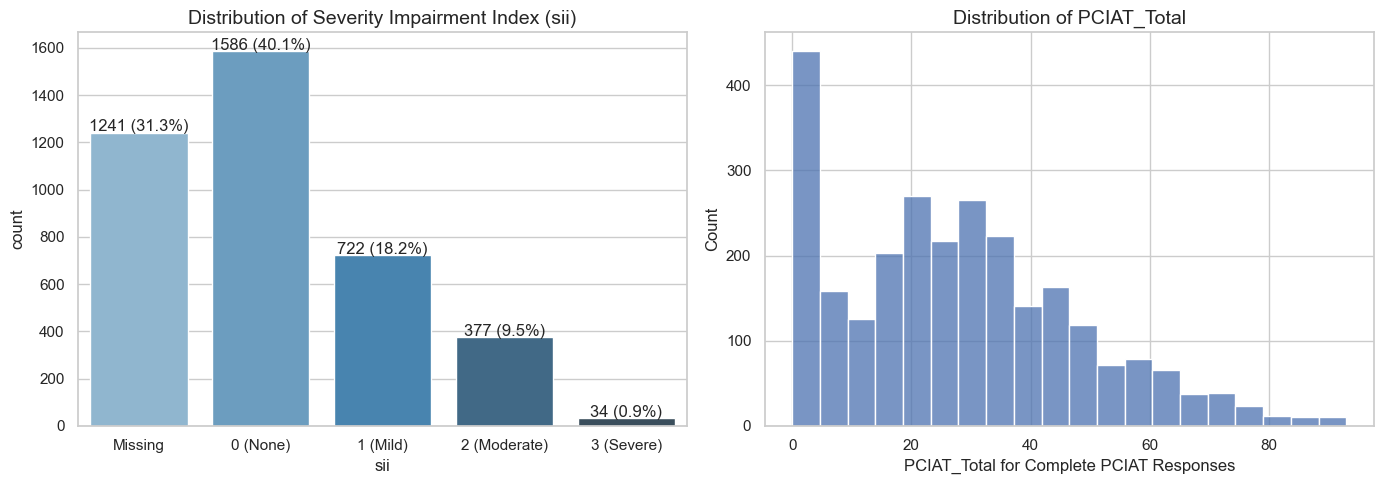

In [185]:
sii_counts = train['sii'].value_counts().reset_index()
total = sii_counts['count'].sum()
sii_counts['percentage'] = (sii_counts['count'] / total) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SII
sns.barplot(x='sii', y='count', data=sii_counts, palette='Blues_d', ax=axes[0])
axes[0].set_title('Distribution of Severity Impairment Index (sii)', fontsize=14)
for p in axes[0].patches:
    height = p.get_height()
    percentage = sii_counts.loc[sii_counts['count'] == height, 'percentage'].values[0]
    axes[0].text(
        p.get_x() + p.get_width() / 2,
        height + 5, f'{int(height)} ({percentage:.1f}%)',
        ha="center", fontsize=12
    )

# PCIAT_Total for complete responses
sns.histplot(train['complete_resp_total'].dropna(), bins=20, ax=axes[1])
axes[1].set_title('Distribution of PCIAT_Total', fontsize=14)
axes[1].set_xlabel('PCIAT_Total for Complete PCIAT Responses')

plt.tight_layout()
plt.show()

In [186]:
len(train[train['complete_resp_total'] == 0])

307

In [187]:
assert train['Basic_Demos-Age'].isna().sum() == 0
assert train['Basic_Demos-Sex'].isna().sum() == 0

In [188]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)
calculate_stats(train, 'Age Group')

,count (%)
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


In [189]:
sex_map = {0: 'Male', 1: 'Female'}
train['Basic_Demos-Sex'] = train['Basic_Demos-Sex'].map(sex_map)
calculate_stats(train, 'Basic_Demos-Sex')

,count (%)
Basic_Demos-Sex,
Male,2484 (62.73%)
Female,1476 (37.27%)


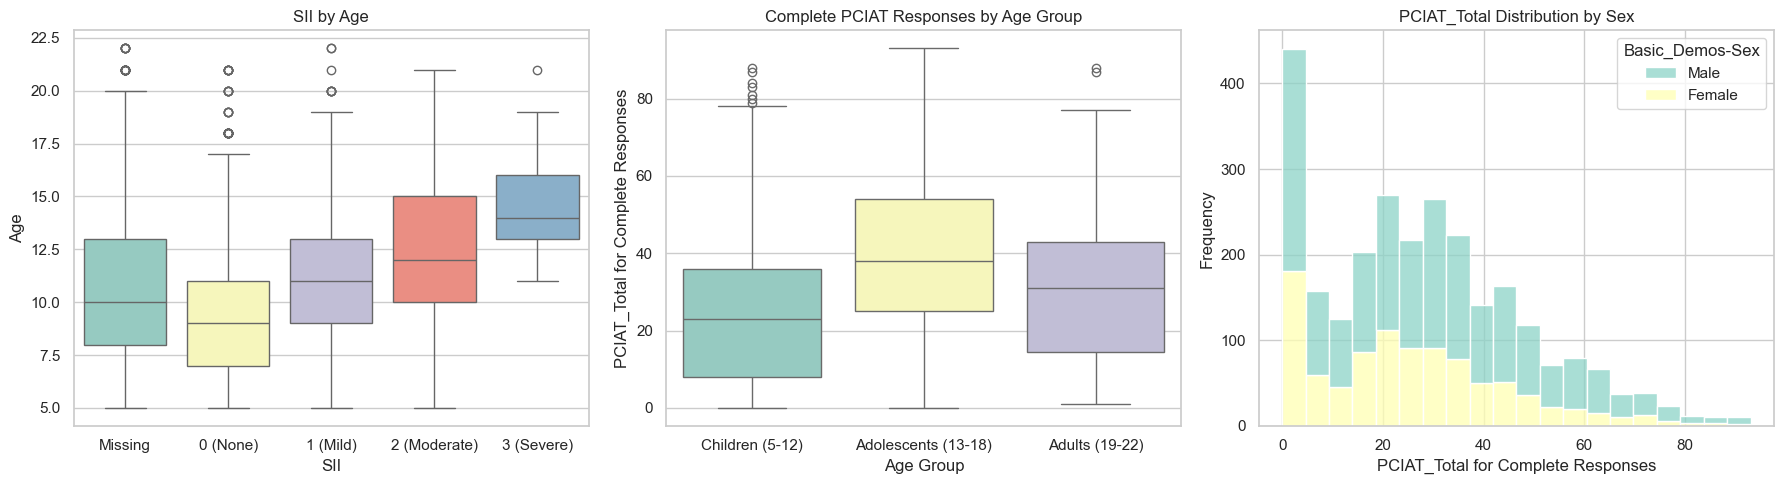

In [190]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# SII by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['sii'], ax=axes[0], palette="Set3")
axes[0].set_title('SII by Age')
axes[0].set_ylabel('Age')
axes[0].set_xlabel('SII')

# Complete PCIAT Responses by Age Group
sns.boxplot(
    x='Age Group', y='complete_resp_total',
    data=train, palette="Set3", ax=axes[1]
)
axes[1].set_title('Complete PCIAT Responses by Age Group')
axes[1].set_ylabel('PCIAT_Total for Complete Responses')
axes[1].set_xlabel('Age Group')

# PCIAT_Total by Sex
sns.histplot(
    data=train, x='complete_resp_total',
    hue='Basic_Demos-Sex', multiple='stack',
    palette="Set3", bins=20, ax=axes[2]
)
axes[2].set_title('PCIAT_Total Distribution by Sex')
axes[2].set_xlabel('PCIAT_Total for Complete Responses')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

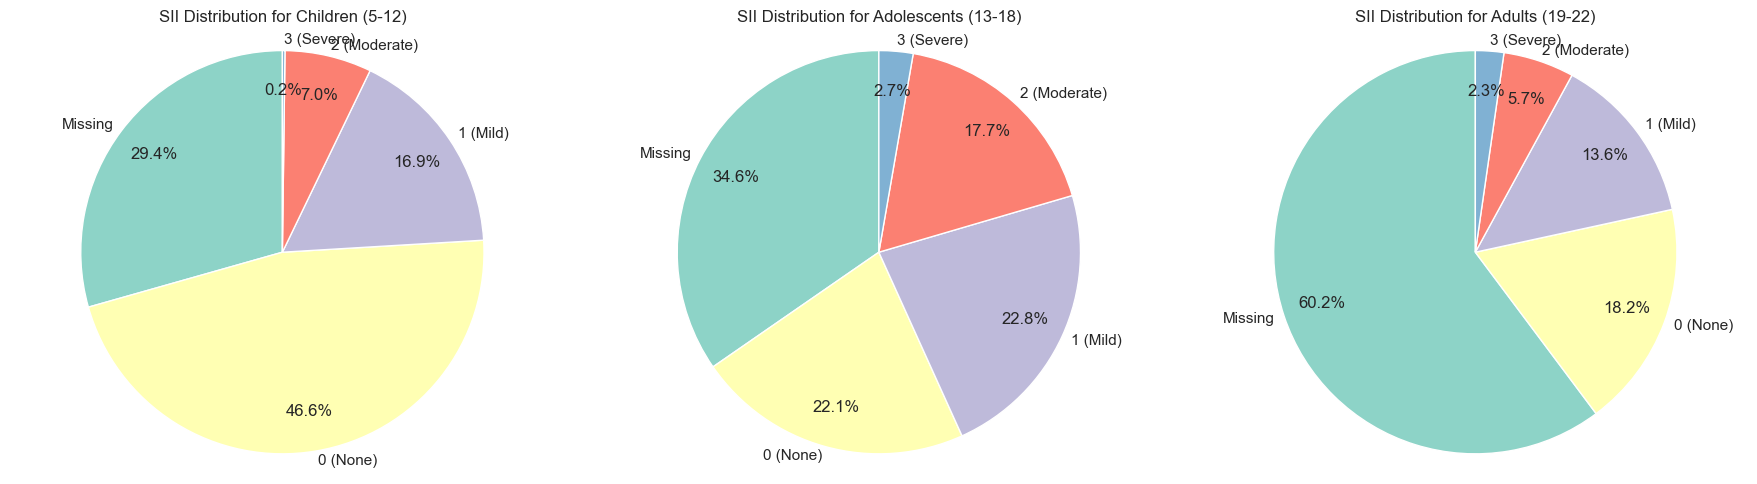

In [191]:
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"),
        labeldistance=1.05, pctdistance=0.80
    )
    axes[i].set_title(f'SII Distribution for {age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()


In [192]:
stats = train.groupby(['Age Group', 'sii']).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,Missing,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,,
Children (5-12),858 (29.4%),1359 (46.6%),493 (16.9%),203 (7.0%),6 (0.2%)
Adolescents (13-18),330 (34.6%),211 (22.1%),217 (22.8%),169 (17.7%),26 (2.7%)
Adults (19-22),53 (60.2%),16 (18.2%),12 (13.6%),5 (5.7%),2 (2.3%)


In [193]:
stats = train[train['sii'] != 'Missing'].groupby(
    ['Age Group', 'sii']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,Missing,0 (None),1 (Mild),2 (Moderate),3 (Severe)
Age Group,,,,,
Children (5-12),0 (0.0%),1359 (65.9%),493 (23.9%),203 (9.8%),6 (0.3%)
Adolescents (13-18),0 (0.0%),211 (33.9%),217 (34.8%),169 (27.1%),26 (4.2%)
Adults (19-22),0 (0.0%),16 (45.7%),12 (34.3%),5 (14.3%),2 (5.7%)


In [194]:
data = train[train['PreInt_EduHx-computerinternet_hoursday'].notna()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with measured PreInt_EduHx-computerinternet_hoursday data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with measured PreInt_EduHx-computerinternet_hoursday data: 5 - 22 years


In [195]:
train['PreInt_EduHx-computerinternet_hoursday'].unique()

array([ 3.,  0.,  2., nan,  1.])

In [196]:
param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

In [197]:
calculate_stats(train, 'PreInt_EduHx-Season')

,count (%)
PreInt_EduHx-Season,
Fall,828 (20.91%)
Summer,821 (20.73%)
Winter,906 (22.88%)
NaN,420 (10.61%)
Spring,985 (24.87%)


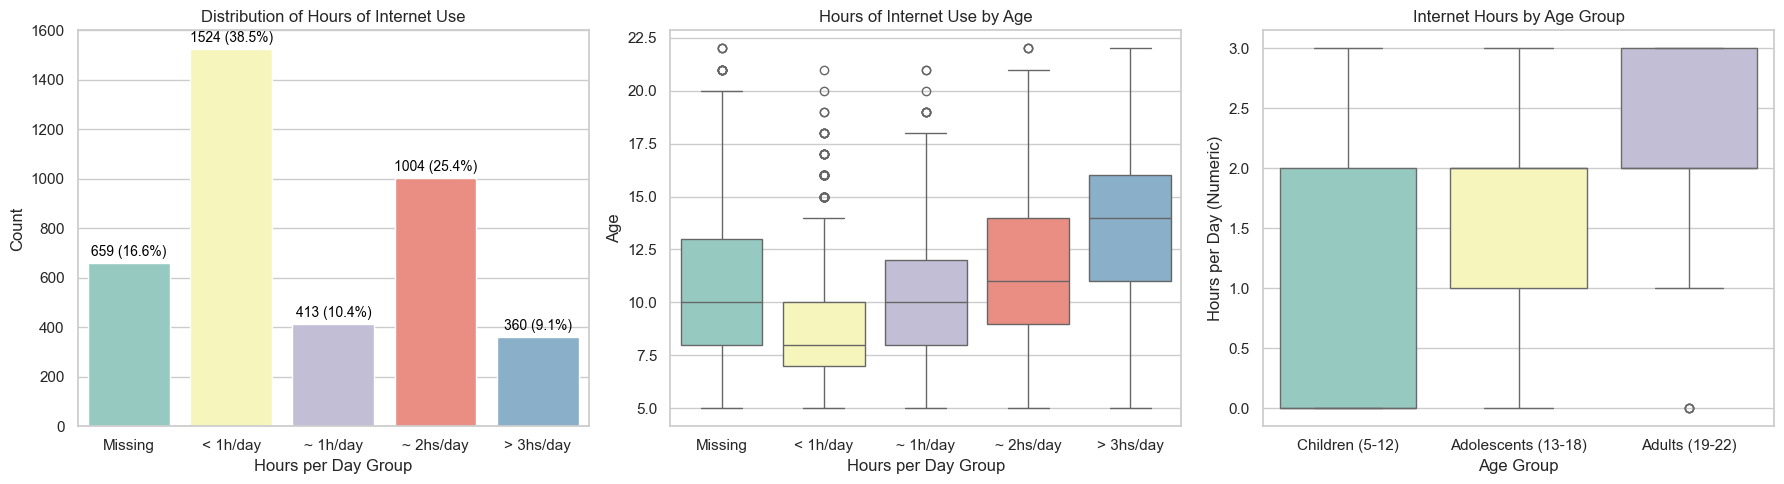

In [198]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hours of Internet Use
ax1 = sns.countplot(x='internet_use_encoded', data=train, palette="Set3", ax=axes[0])
axes[0].set_title('Distribution of Hours of Internet Use')
axes[0].set_xlabel('Hours per Day Group')
axes[0].set_ylabel('Count')

total = len(train['internet_use_encoded'])
for p in ax1.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax1.annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                 textcoords='offset points')

# Hours of Internet Use by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['internet_use_encoded'], ax=axes[1], palette="Set3")
axes[1].set_title('Hours of Internet Use by Age')
axes[1].set_ylabel('Age')
axes[1].set_xlabel('Hours per Day Group')

# Hours of Internet Use (numeric) by Age Group
sns.boxplot(y='PreInt_EduHx-computerinternet_hoursday', x='Age Group', data=train, ax=axes[2], palette="Set3")
axes[2].set_title('Internet Hours by Age Group')
axes[2].set_ylabel('Hours per Day (Numeric)')
axes[2].set_xlabel('Age Group')

plt.tight_layout()
plt.show()

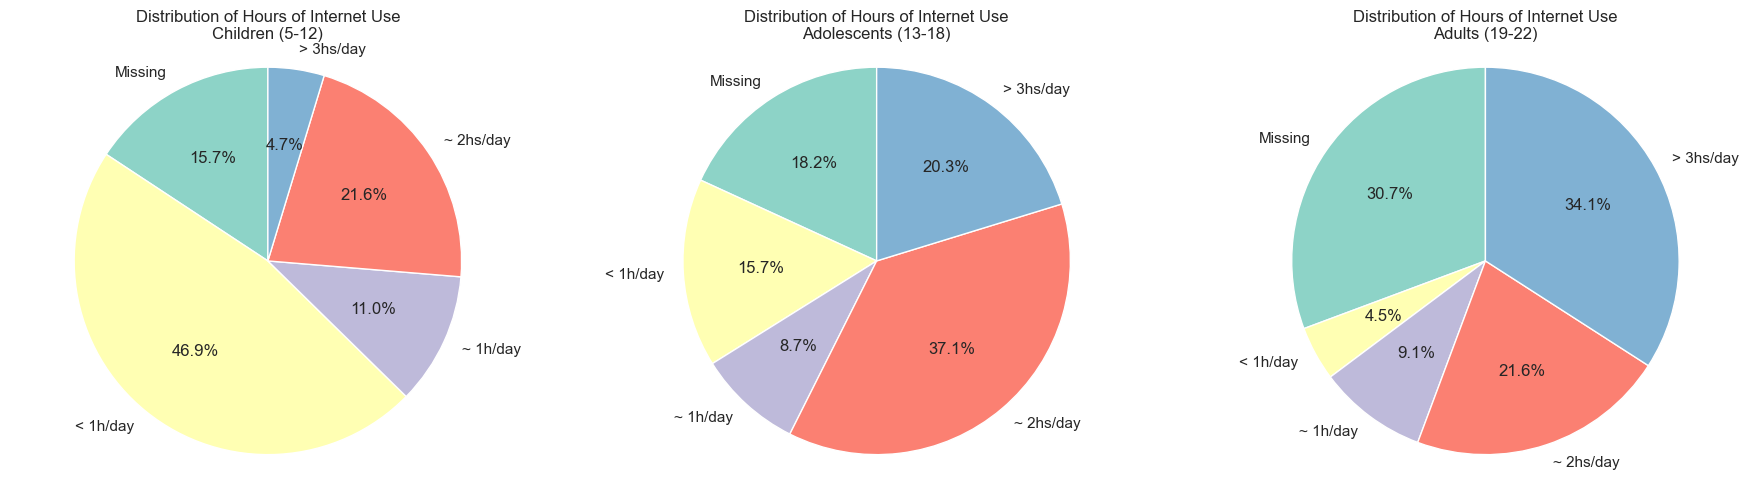

In [199]:
stats = train.groupby(
    ['Age Group', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, age_group in enumerate(stats.index):
    group_counts = stats.loc[age_group] / stats.loc[age_group].sum()
    axes[i].pie(group_counts, labels=group_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1)
    axes[i].set_title(f'Distribution of Hours of Internet Use\n{age_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

In [200]:
train_non_na = train.dropna(subset=['PreInt_EduHx-computerinternet_hoursday'])
rows = (train_non_na['PreInt_EduHx-computerinternet_hoursday'] == 3).sum()
print(f"Non-NA Rows - Internet use 3h or more: {(rows / len(train_non_na)) * 100:.2f}%")

rows = (train_non_na['PreInt_EduHx-computerinternet_hoursday'] == 0).sum()
print(f"Non-NA Rows - Internet use 1h or less: {(rows / len(train_non_na)) * 100:.2f}%")

Non-NA Rows - Internet use 3h or more: 10.91%
Non-NA Rows - Internet use 1h or less: 46.17%


In [201]:
stats = train.groupby(['Basic_Demos-Sex', 'internet_use_encoded']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

internet_use_encoded,Missing,< 1h/day,~ 1h/day,~ 2hs/day,> 3hs/day
Basic_Demos-Sex,,,,,
Female,271 (18.4%),569 (38.6%),139 (9.4%),353 (23.9%),144 (9.8%)
Male,388 (15.6%),955 (38.4%),274 (11.0%),651 (26.2%),216 (8.7%)


In [202]:
sii_reported = train[train['sii'] != "Missing"]
sii_reported.loc[:, 'sii'] = sii_reported['sii'].cat.remove_unused_categories()

In [203]:
stats = sii_reported.groupby(
    ['internet_use_encoded', 'sii']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

sii,0 (None),1 (Mild),2 (Moderate),3 (Severe)
internet_use_encoded,,,,
Missing,52 (63.4%),15 (18.3%),15 (18.3%),0 (0.0%)
< 1h/day,933 (73.9%),247 (19.6%),78 (6.2%),5 (0.4%)
~ 1h/day,160 (47.2%),123 (36.3%),54 (15.9%),2 (0.6%)
~ 2hs/day,366 (47.2%),251 (32.3%),147 (18.9%),12 (1.5%)
> 3hs/day,75 (29.0%),86 (33.2%),83 (32.0%),15 (5.8%)


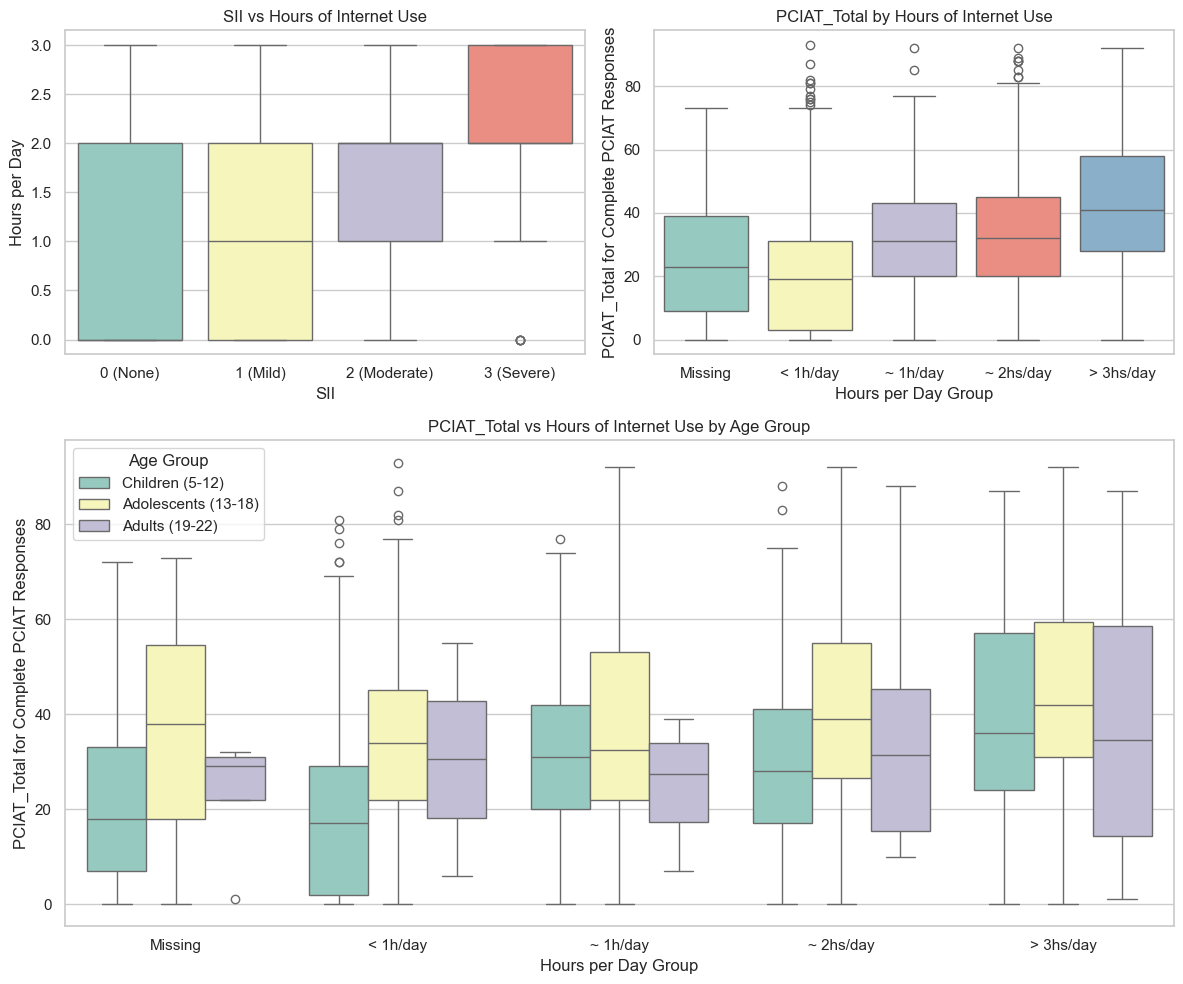

In [204]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5])

# SII vs Hours of Internet Use
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(
    x='sii', y='PreInt_EduHx-computerinternet_hoursday',
    data=sii_reported,
    ax=ax1, palette="Set3"
)
ax1.set_title('SII vs Hours of Internet Use')
ax1.set_ylabel('Hours per Day')
ax1.set_xlabel('SII')

# PCIAT_Total for Complete PCIAT Responses by Hours of Internet Use
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(
    x='internet_use_encoded', y='complete_resp_total',
    data=sii_reported,
    palette="Set3", ax=ax2
)
ax2.set_title('PCIAT_Total by Hours of Internet Use')
ax2.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax2.set_xlabel('Hours per Day Group')

# SII vs Hours of Internet Use by Age Group (Full width)
ax3 = fig.add_subplot(gs[1, :])
sns.boxplot(
    x='internet_use_encoded', y='complete_resp_total',
    data=sii_reported,
    hue='Age Group', ax=ax3, palette="Set3"
)
ax3.set_title('PCIAT_Total vs Hours of Internet Use by Age Group')
ax3.set_ylabel('PCIAT_Total for Complete PCIAT Responses')
ax3.set_xlabel('Hours per Day Group')

plt.tight_layout()
plt.show()

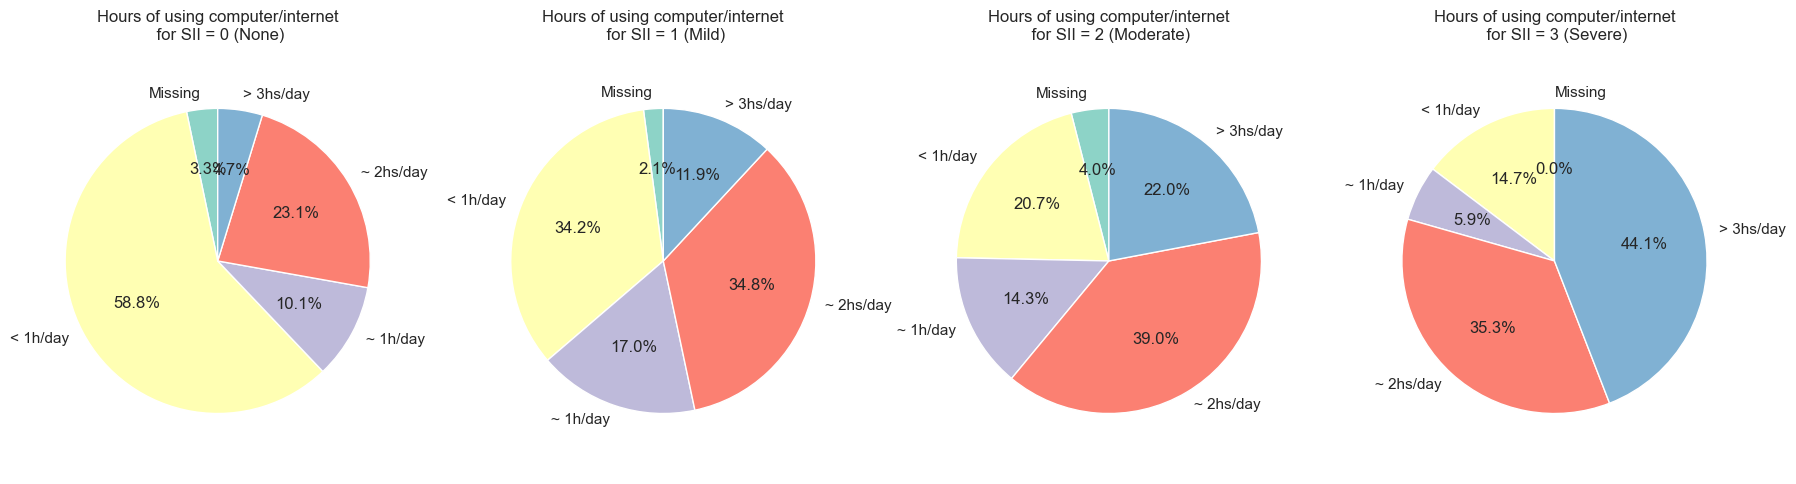

In [205]:
stats = sii_reported.groupby(
    ['sii', 'internet_use_encoded']
).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, len(stats), figsize=(18, 5))

for i, sii_group in enumerate(stats.index):
    group_counts = stats.loc[sii_group] / stats.loc[sii_group].sum()
    axes[i].pie(
        group_counts, labels=group_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette("Set3"), labeldistance=1.1
    )
    axes[i].set_title(f'Hours of using computer/internet\n for SII = {sii_group}')
    axes[i].axis('equal')

plt.tight_layout()
plt.show()

In [206]:
stats = sii_reported.groupby(
    ['sii', 'internet_use_encoded']
).size().unstack(fill_value=0)
stats_prop = stats.div(stats.sum(axis=1), axis=0) * 100

stats = stats.astype(str) +' (' + stats_prop.round(1).astype(str) + '%)'
stats

internet_use_encoded,Missing,< 1h/day,~ 1h/day,~ 2hs/day,> 3hs/day
sii,,,,,
0 (None),52 (3.3%),933 (58.8%),160 (10.1%),366 (23.1%),75 (4.7%)
1 (Mild),15 (2.1%),247 (34.2%),123 (17.0%),251 (34.8%),86 (11.9%)
2 (Moderate),15 (4.0%),78 (20.7%),54 (14.3%),147 (39.0%),83 (22.0%)
3 (Severe),0 (0.0%),5 (14.7%),2 (5.9%),12 (35.3%),15 (44.1%)


In [207]:
train[
    (train['internet_use_encoded'] == '< 1h/day') & 
    (train['sii'].isin(['2 (Moderate)', '3 (Severe)']))
]['Basic_Demos-Age'].describe()

count    83.000000
mean     10.626506
std       3.083041
min       5.000000
25%       8.500000
50%      10.000000
75%      12.500000
max      21.000000
Name: Basic_Demos-Age, dtype: float64

In [208]:
groups = data_dict.groupby('Instrument')['Field'].apply(list).to_dict()

for instrument, features in groups.items():
    print(f"{instrument}: {features}\n")

Bio-electric Impedance Analysis: ['BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW']

Children's Global Assessment Scale: ['CGAS-Season', 'CGAS-CGAS_Score']

Demographics: ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

FitnessGram Child: ['FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone']

FitnessGram Vitals and Treadmill: ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec']

Identifier: ['id']

Internet Use: ['PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']

P

In [209]:
season_columns = [col for col in train.columns if 'Season' in col]
season_df = train[season_columns]
season_df

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,Fitness_Endurance-Season,FGC-Season,BIA-Season,PAQ_A-Season,PAQ_C-Season,PCIAT-Season,SDS-Season,PreInt_EduHx-Season
0,Fall,Winter,Fall,NaN,Fall,Fall,NaN,NaN,Fall,NaN,Fall
1,Summer,NaN,Fall,NaN,Fall,Winter,NaN,Fall,Fall,Fall,Summer
2,Summer,Fall,Fall,Fall,Fall,NaN,NaN,Summer,Fall,Fall,Summer
3,Winter,Fall,Summer,Summer,Summer,Summer,NaN,Winter,Summer,Summer,Winter
4,Spring,Summer,NaN,NaN,NaN,NaN,Summer,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3955,Fall,Spring,Fall,NaN,Fall,Fall,NaN,Winter,Winter,Winter,Fall
3956,Winter,NaN,Spring,NaN,Spring,Spring,NaN,Winter,NaN,NaN,Winter
3957,Fall,Spring,Winter,NaN,Winter,Winter,NaN,Winter,Winter,Winter,Fall
3958,Spring,Spring,Winter,NaN,Spring,Summer,NaN,Spring,Spring,Spring,Spring


In [210]:
train[season_columns] = train[season_columns].fillna("Missing")

In [211]:
data_dict = data_dict[data_dict['Instrument'] != 'Parent-Child Internet Addiction Test']
continuous_cols = data_dict[data_dict['Type'].str.contains(
    'float|int', case=False
)]['Field'].tolist()

# target = train[['sii']]
# train = train.drop(columns = columns_not_in_test)

In [212]:
groups.get('Demographics', [])

['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex']

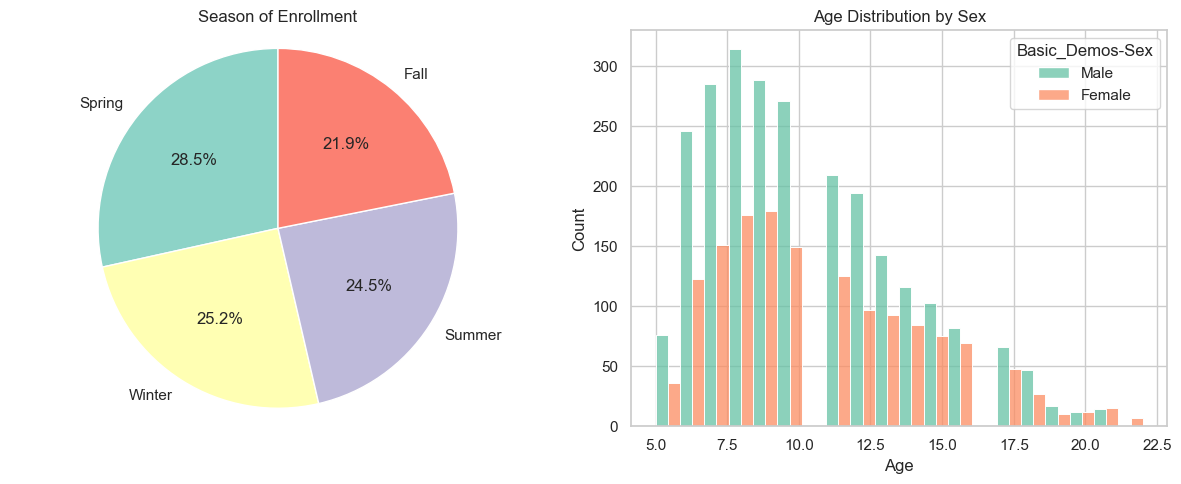

In [213]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Season of Enrollment
season_counts = train['Basic_Demos-Enroll_Season'].value_counts(dropna=False)

axes[0].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[0].set_title('Season of Enrollment')
axes[0].axis('equal')

# Age Distribution by Sex
sns.histplot(
    data=train, x='Basic_Demos-Age',
    hue='Basic_Demos-Sex', multiple='dodge',
    palette="Set2", bins=20, ax=axes[1]
)
axes[1].set_title('Age Distribution by Sex')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [214]:
calculate_stats(train, 'Basic_Demos-Age')

,count,mean,std,min,25%,50%,75%,max,missing
Basic_Demos-Age,,,,,,,,,
Basic_Demos-Age,3960.0,10.433586,3.574648,5.0,8.0,10.0,13.0,22.0,0


In [215]:
groups.get("Children's Global Assessment Scale", [])

['CGAS-Season', 'CGAS-CGAS_Score']

In [216]:
data = train[train['CGAS-CGAS_Score'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with CGAS-CGAS_Score data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with CGAS-CGAS_Score data: 5 - 22 years


In [217]:
calculate_stats(train, 'CGAS-CGAS_Score')

,count,mean,std,min,25%,50%,75%,max,missing
CGAS-CGAS_Score,,,,,,,,,
CGAS-CGAS_Score,2421.0,65.454771,22.341862,25.0,59.0,65.0,75.0,999.0,1539


In [218]:
train[train['CGAS-CGAS_Score'] > 100]

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,complete_resp_total,Age Group,internet_use_encoded
2065,83525bbe,Fall,11,Female,Winter,999.0,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,NaN,NaN,NaN,Fall,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,NaN,Fall,2.241,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,NaN,NaN,Fall,3.0,Missing,NaN,Children (5-12),> 3hs/day


In [219]:
train.loc[train['CGAS-CGAS_Score'] == 999, 'CGAS-CGAS_Score'] = np.nan

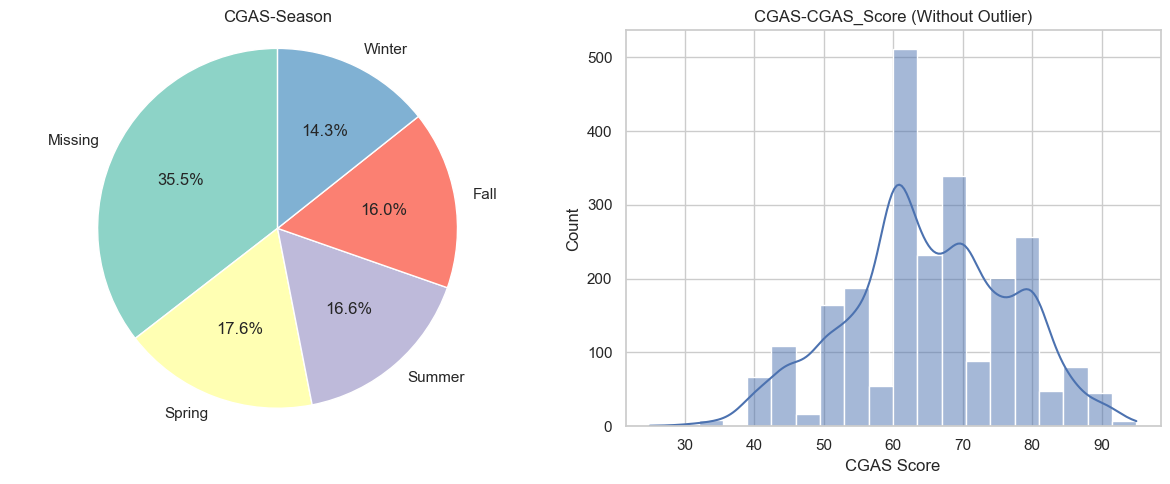

In [220]:
plt.figure(figsize=(12, 5))

# CGAS-Season
plt.subplot(1, 2, 1)
cgas_season_counts = train['CGAS-Season'].value_counts(normalize=True)
plt.pie(
    cgas_season_counts, 
    labels=cgas_season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
plt.title('CGAS-Season')
plt.axis('equal')

# CGAS-CGAS_Score without outliers (score == 999)
plt.subplot(1, 2, 2)
sns.histplot(
    train['CGAS-CGAS_Score'].dropna(),
    bins=20, kde=True
)
plt.title('CGAS-CGAS_Score (Without Outlier)')
plt.xlabel('CGAS Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [221]:
calculate_stats(train, 'CGAS-CGAS_Score')

,count,mean,std,min,25%,50%,75%,max,missing
CGAS-CGAS_Score,,,,,,,,,
CGAS-CGAS_Score,2420.0,65.069008,11.78731,25.0,59.0,65.0,75.0,95.0,1540


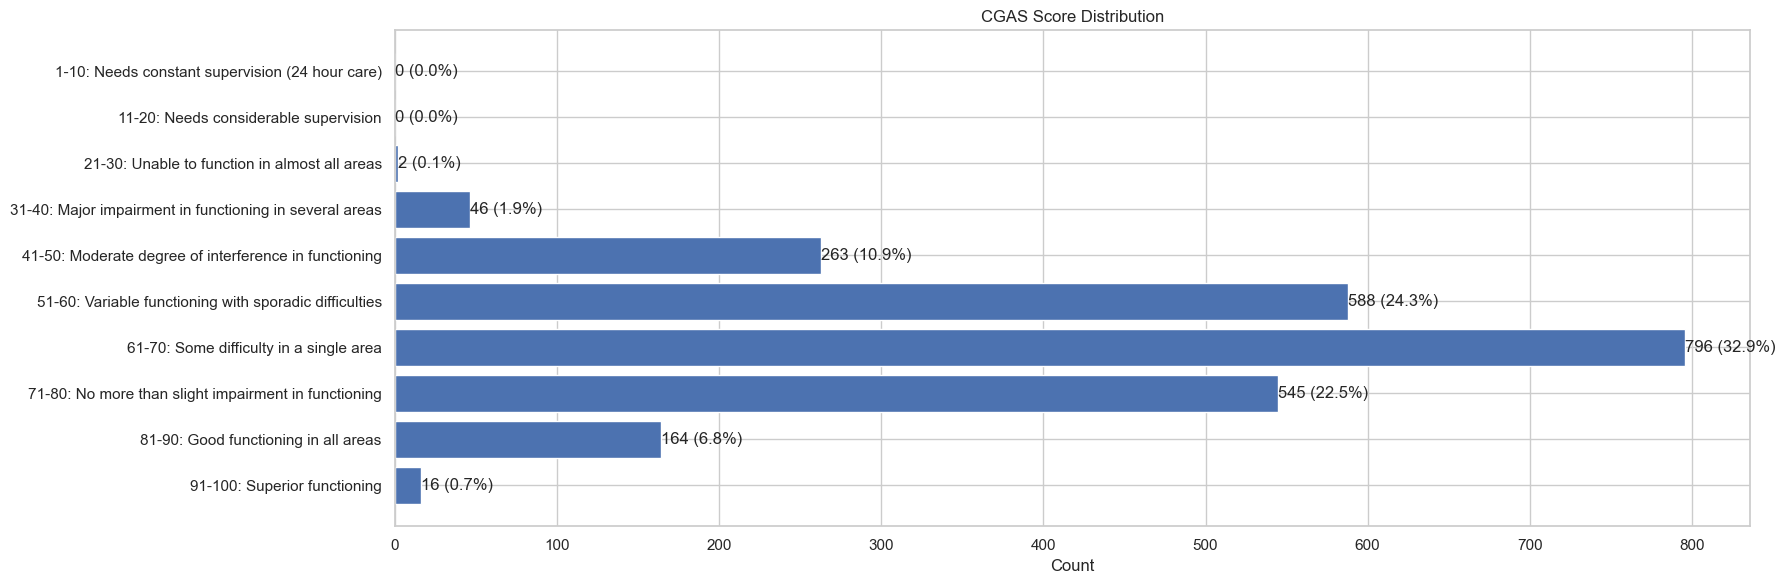

In [222]:
bins = np.arange(0, 101, 10)
labels = [
    "1-10: Needs constant supervision (24 hour care)",
    "11-20: Needs considerable supervision",
    "21-30: Unable to function in almost all areas",
    "31-40: Major impairment in functioning in several areas",
    "41-50: Moderate degree of interference in functioning",
    "51-60: Variable functioning with sporadic difficulties",
    "61-70: Some difficulty in a single area",
    "71-80: No more than slight impairment in functioning",
    "81-90: Good functioning in all areas",
    "91-100: Superior functioning"
]

train['CGAS_Score_Bin'] = pd.cut(
    train['CGAS-CGAS_Score'], bins=bins, labels=labels
)

counts = train['CGAS_Score_Bin'].value_counts().reindex(labels)
prop = (counts / counts.sum() * 100).round(1)
count_prop_labels = counts.astype(str) + " (" + prop.astype(str) + "%)"

plt.figure(figsize=(18, 6))
bars = plt.barh(labels, counts)
plt.xlabel('Count')
plt.title('CGAS Score Distribution')

for bar, label in zip(bars, count_prop_labels):
    plt.text(
        bar.get_width(), bar.get_y() + bar.get_height() / 2, label, va='center'
    )

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [223]:
train_filt = train.dropna(subset=['CGAS_Score_Bin', 'complete_resp_total'])
train_filt.loc[:, 'CGAS_Score_Bin'] = train_filt['CGAS_Score_Bin'].cat.remove_unused_categories()
train_filt.loc[:, 'sii'] = train_filt['sii'].cat.remove_unused_categories()
len(train_filt)

2288

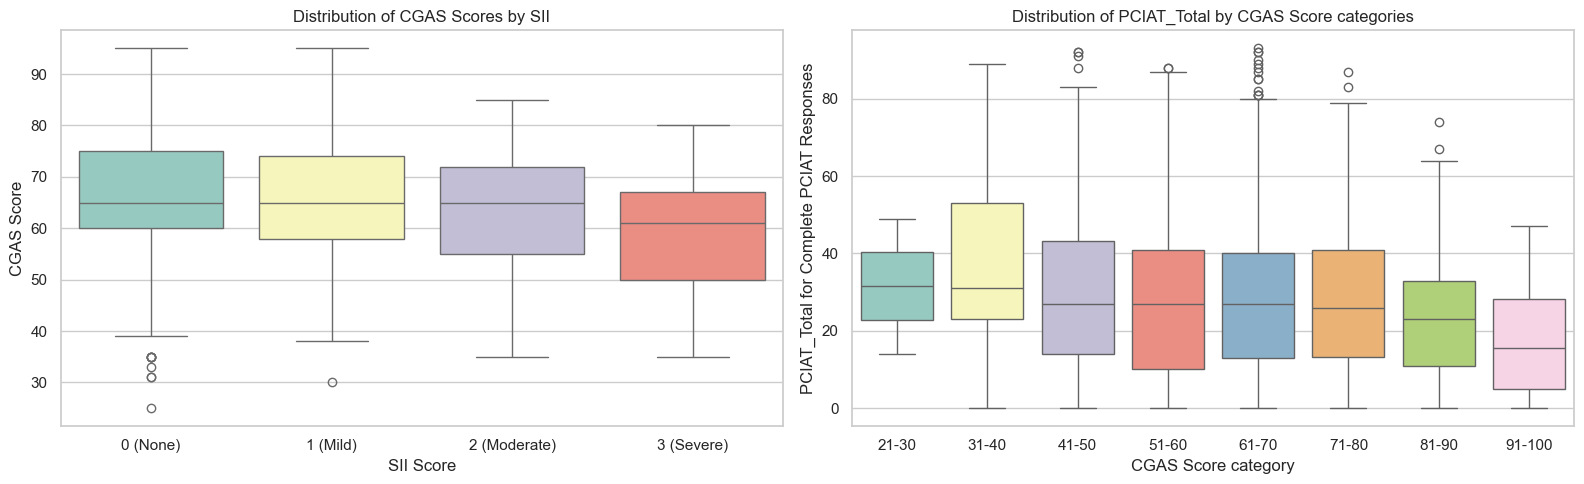

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# CGAS-CGAS_Score vs sii
sns.boxplot(
    data=train_filt,
    x='sii', y='CGAS-CGAS_Score',
    palette='Set3', ax=axes[0]
)
axes[0].set_xlabel('SII Score')
axes[0].set_ylabel('CGAS Score')
axes[0].set_title('Distribution of CGAS Scores by SII')

# complete_resp_total vs CGAS_Score_Bin
sns.boxplot(
    data=train_filt,
    x='CGAS_Score_Bin', y='complete_resp_total',
    ax=axes[1], palette='Set3'
)

# Get the tick positions and match the labels
range_labels = [label.split(":")[0] for label in train_filt['CGAS_Score_Bin'].cat.categories]
axes[1].set_xticklabels(range_labels)

axes[1].set_xlabel('CGAS Score category')
axes[1].set_ylabel('PCIAT_Total for Complete PCIAT Responses')
axes[1].set_title('Distribution of PCIAT_Total by CGAS Score categories')

plt.tight_layout()
plt.show()

In [225]:
score_min_max = train.groupby('sii')['CGAS-CGAS_Score'].agg(['min', 'max'])
score_min_max = score_min_max.rename(
    columns={'min': 'Minimum CGAS Score', 'max': 'Maximum CGAS Score'}
)
score_min_max

,Minimum CGAS Score,Maximum CGAS Score
sii,,
Missing,40.0,85.0
0 (None),25.0,95.0
1 (Mild),30.0,95.0
2 (Moderate),35.0,85.0
3 (Severe),35.0,80.0


In [226]:
train_filt[train_filt['CGAS-CGAS_Score'] < 35][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

,Basic_Demos-Age,Basic_Demos-Sex,sii,CGAS-CGAS_Score,PreInt_EduHx-computerinternet_hoursday
2417,9,Female,0 (None),31.0,0.0
2525,13,Female,1 (Mild),30.0,0.0
2555,15,Male,0 (None),33.0,2.0
3332,12,Male,0 (None),25.0,2.0
3858,15,Male,0 (None),31.0,3.0


In [227]:
train[train['CGAS-CGAS_Score'] > 90][
    ['Basic_Demos-Age', 'Basic_Demos-Sex', 'sii',
     'CGAS-CGAS_Score',
     'PreInt_EduHx-computerinternet_hoursday']
]

,Basic_Demos-Age,Basic_Demos-Sex,sii,CGAS-CGAS_Score,PreInt_EduHx-computerinternet_hoursday
310,13,Female,0 (None),91.0,2.0
591,10,Female,0 (None),93.0,NaN
667,13,Male,0 (None),95.0,0.0
910,10,Female,0 (None),91.0,0.0
1007,14,Male,1 (Mild),95.0,0.0
1157,14,Female,1 (Mild),91.0,2.0
1640,11,Female,0 (None),92.0,0.0
2342,6,Female,0 (None),91.0,0.0
2668,14,Female,0 (None),92.0,0.0
2675,11,Male,0 (None),91.0,0.0


In [228]:
groups.get('Physical Measures', [])

['Physical-Season',
 'Physical-BMI',
 'Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Physical-Diastolic_BP',
 'Physical-HeartRate',
 'Physical-Systolic_BP']

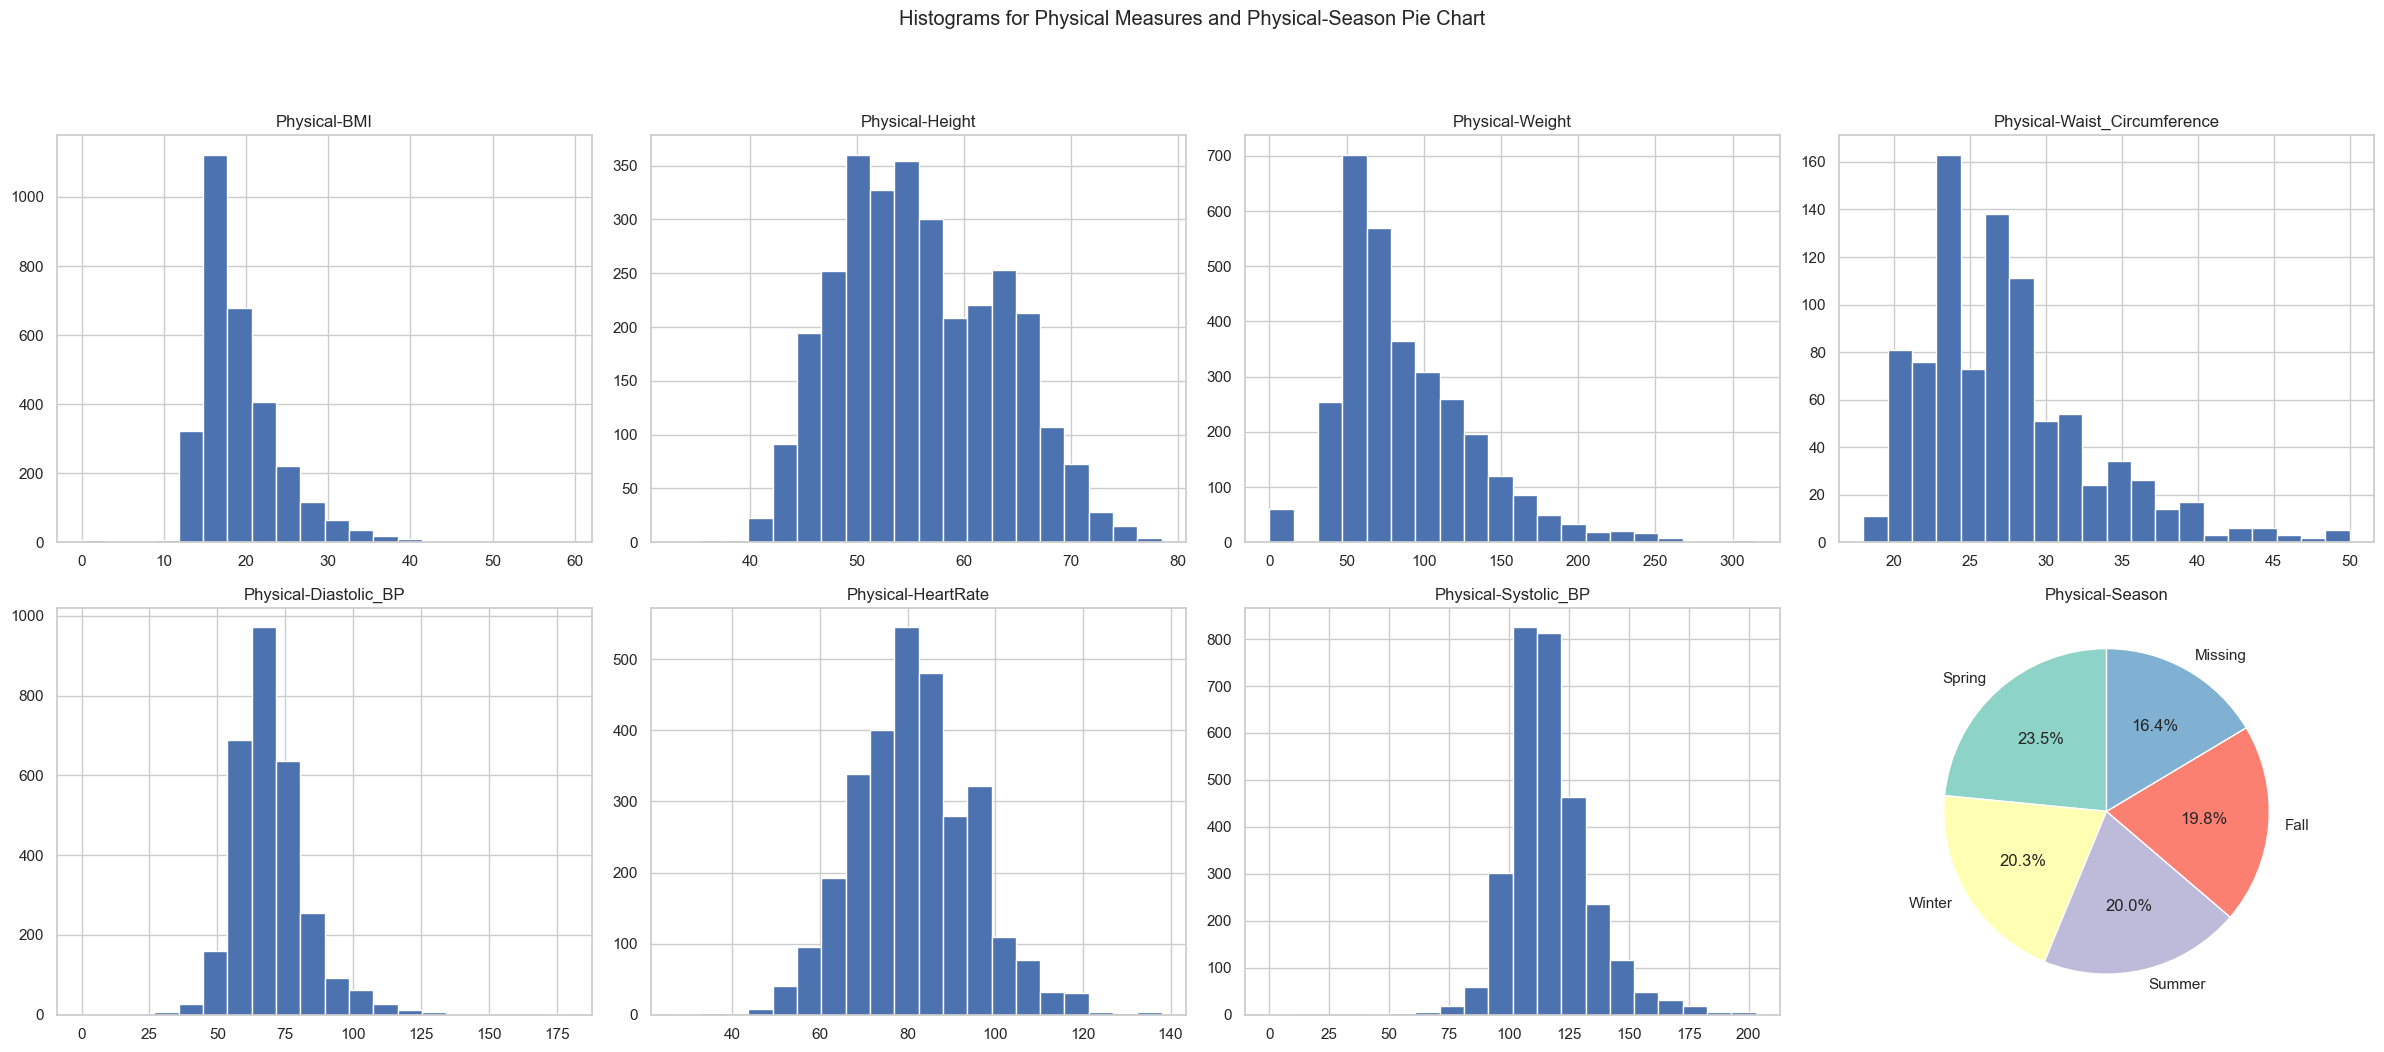

In [229]:
features_physical = groups.get('Physical Measures', [])
cols = [col for col in features_physical if col in continuous_cols]

plt.figure(figsize=(24, 10))
n_cols = 4
n_rows = len(cols) // n_cols + 1

for i, col in enumerate(cols):
    plt.subplot(n_rows, n_cols, i + 1)
    train[col].hist(bins=20)
    plt.title(col)

plt.subplot(n_rows, n_cols, len(cols) + 1)
season_counts = train['Physical-Season'].value_counts(dropna=False)
plt.pie(
    season_counts,
    labels=season_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set3")
)
plt.title('Physical-Season')

plt.suptitle('Histograms for Physical Measures and Physical-Season Pie Chart', y=1.05)
plt.tight_layout()
plt.show()

In [230]:
calculate_stats(train, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3022.0,19.331929,5.113934,0.0,15.86935,17.937682,21.571244,59.132048,938
Physical-Height,3027.0,55.946713,7.473764,33.0,50.00000,55.000000,62.000000,78.500000,933
Physical-Weight,3076.0,89.038615,44.569040,0.0,57.20000,77.000000,113.800000,315.000000,884
Physical-Waist_Circumference,898.0,27.278508,5.567287,18.0,23.00000,26.000000,30.000000,50.000000,3062
Physical-Diastolic_BP,2954.0,69.648951,13.611226,0.0,61.00000,68.000000,76.000000,179.000000,1006
Physical-HeartRate,2967.0,81.597236,13.665196,27.0,72.00000,81.000000,90.500000,138.000000,993
Physical-Systolic_BP,2954.0,116.983074,17.061225,0.0,107.00000,114.000000,125.000000,203.000000,1006


In [231]:
wh_cols = [
    'Physical-BMI', 'Physical-Height',
    'Physical-Weight', 'Physical-Waist_Circumference'
]

In [232]:
(train[wh_cols] == 0).sum()

Physical-BMI                     7
Physical-Height                  0
Physical-Weight                 61
Physical-Waist_Circumference     0
dtype: int64

In [233]:
train[wh_cols] = train[wh_cols].replace(0, np.nan)
calculate_stats(train, wh_cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3015.0,19.376812,5.034191,8.522436,15.890526,17.950925,21.588631,59.132048,945
Physical-Height,3027.0,55.946713,7.473764,33.000000,50.000000,55.000000,62.000000,78.500000,933
Physical-Weight,3015.0,90.840060,43.161374,31.800000,58.200000,77.800000,114.300000,315.000000,945
Physical-Waist_Circumference,898.0,27.278508,5.567287,18.000000,23.000000,26.000000,30.000000,50.000000,3062


In [234]:
lbs_to_kg = 0.453592
inches_to_cm = 2.54

train['Physical-Weight'] = train['Physical-Weight'] * lbs_to_kg
train['Physical-Height'] = train['Physical-Height'] * inches_to_cm
train['Physical-Waist_Circumference'] = train['Physical-Waist_Circumference'] * inches_to_cm

# Recalculate BMI: BMI = weight (kg) / (height (m)^2)
train['Physical-BMI'] = np.where(
    train['Physical-Weight'].notna() & train['Physical-Height'].notna(),
    train['Physical-Weight'] / ((train['Physical-Height'] / 100) ** 2),
    np.nan  # If either is NaN, set BMI to NaN
)

calculate_stats(train, wh_cols)

,count,mean,std,min,25%,50%,75%,max,missing
Physical-BMI,3015.0,19.378674,5.034658,8.523273,15.892086,17.952687,21.590750,59.137852,945
Physical-Height,3027.0,142.104651,18.983360,83.820000,127.000000,139.700000,157.480000,199.390000,933
Physical-Weight,3015.0,41.204324,19.577654,14.424226,26.399054,35.289458,51.845566,142.881480,945
Physical-Waist_Circumference,898.0,69.287410,14.140909,45.720000,58.420000,66.040000,76.200000,127.000000,3062


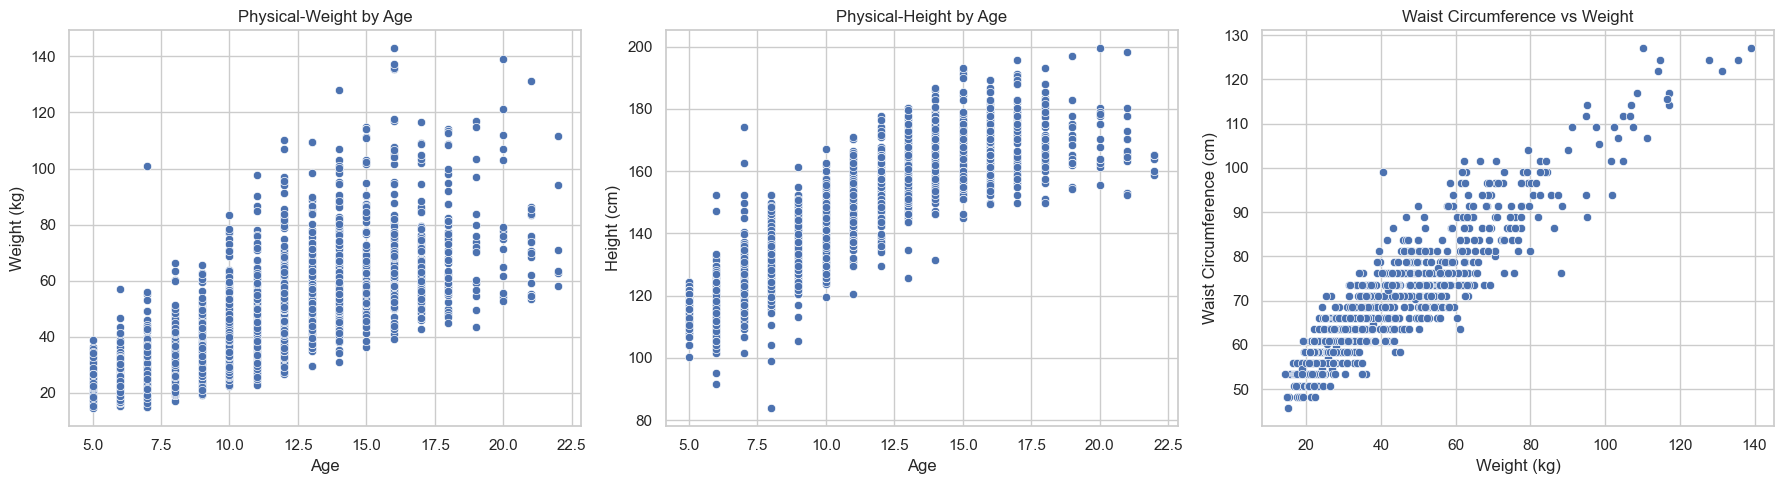

In [235]:
plt.figure(figsize=(18, 5))

# Physical-Weight by Age
plt.subplot(1, 3, 1)
sns.scatterplot(x='Basic_Demos-Age', y='Physical-Weight', data=train)
plt.title('Physical-Weight by Age')
plt.xlabel('Age')
plt.ylabel('Weight (kg)')

# Physical-Height by Age
plt.subplot(1, 3, 2)
sns.scatterplot(x='Basic_Demos-Age', y='Physical-Height', data=train)
plt.title('Physical-Height by Age')
plt.xlabel('Age')
plt.ylabel('Height (cm)')

# Physical-Waist_Circumference vs Physical-Weight
plt.subplot(1, 3, 3)
sns.scatterplot(x='Physical-Weight', y='Physical-Waist_Circumference', data=train)
plt.title('Waist Circumference vs Weight')
plt.xlabel('Weight (kg)')
plt.ylabel('Waist Circumference (cm)')

plt.tight_layout()
plt.show()


In [236]:
bp_hr_cols = [
    'Physical-Diastolic_BP', 'Physical-Systolic_BP',
    'Physical-HeartRate'
]

In [237]:
(train[bp_hr_cols] < 50).sum()

Physical-Diastolic_BP    88
Physical-Systolic_BP      2
Physical-HeartRate       12
dtype: int64

In [238]:
train[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP']][bp_hr_cols]

,Physical-Diastolic_BP,Physical-Systolic_BP,Physical-HeartRate
1140,179.0,139.0,103.0
1879,117.0,114.0,114.0
2386,76.0,76.0,116.0
3199,0.0,0.0,NaN
3344,98.0,73.0,96.0


In [239]:
train[cols] = train[cols].replace(0, np.nan)
train.loc[train['Physical-Systolic_BP'] <= train['Physical-Diastolic_BP'], bp_hr_cols] = np.nan

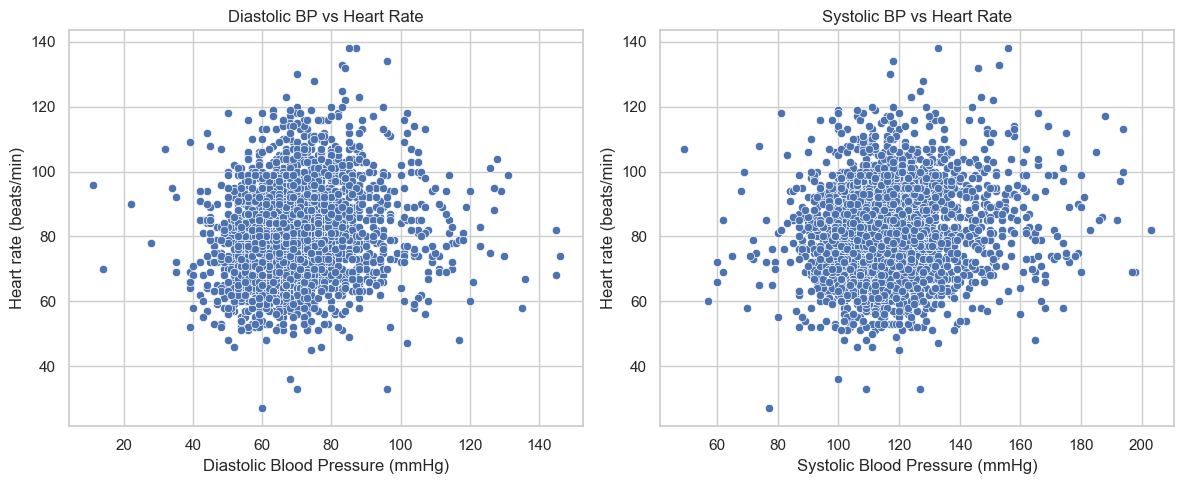

In [240]:
plt.figure(figsize=(12, 5))

# Diastolic BP vs Heart Rate
plt.subplot(1, 2, 1)
sns.scatterplot(x='Physical-Diastolic_BP', y='Physical-HeartRate', data=train)
plt.title('Diastolic BP vs Heart Rate')
plt.xlabel('Diastolic Blood Pressure (mmHg)')
plt.ylabel('Heart rate (beats/min)')

# Systolic BP vs Heart Rate
plt.subplot(1, 2, 2)
sns.scatterplot(x='Physical-Systolic_BP', y='Physical-HeartRate', data=train)
plt.title('Systolic BP vs Heart Rate')
plt.xlabel('Systolic Blood Pressure (mmHg)')
plt.ylabel('Heart rate (beats/min)')

plt.tight_layout()
plt.show()

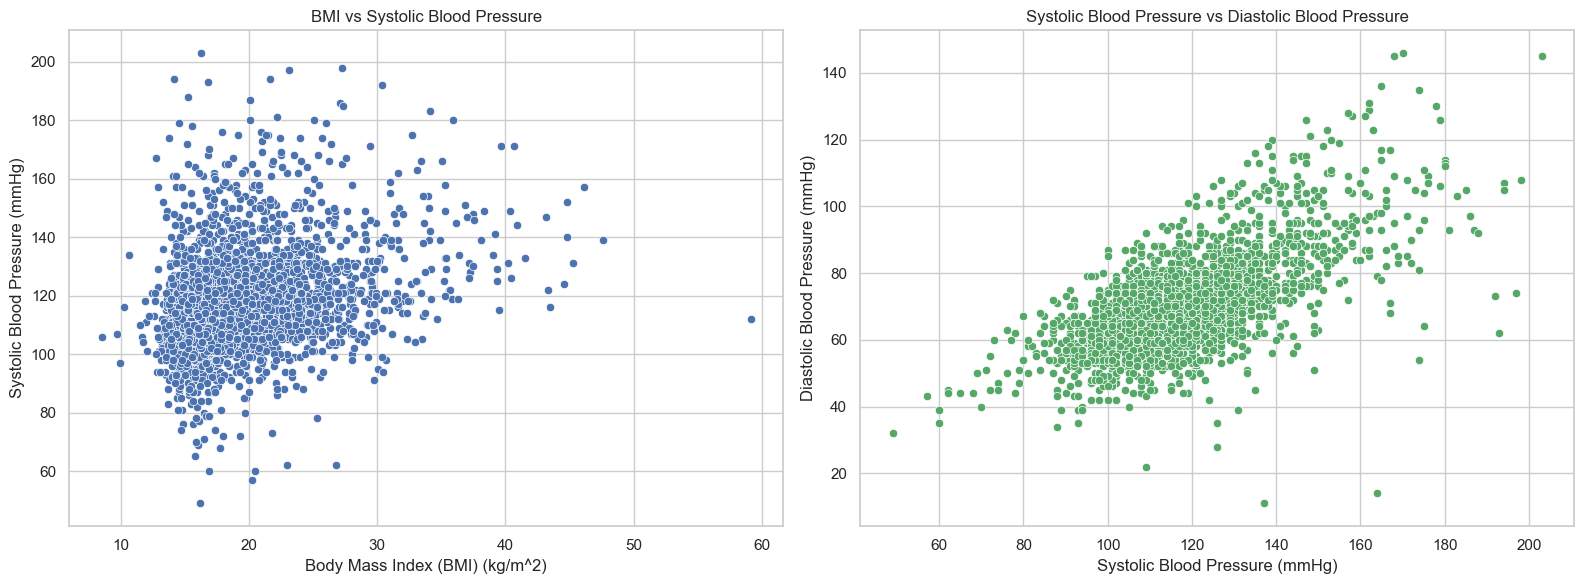

In [241]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# BMI vs Systolic Blood Pressure
sns.scatterplot(x='Physical-BMI', y='Physical-Systolic_BP', data=train, ax=axes[0], color='b')
axes[0].set_title('BMI vs Systolic Blood Pressure')
axes[0].set_xlabel('Body Mass Index (BMI) (kg/m^2)')
axes[0].set_ylabel('Systolic Blood Pressure (mmHg)')

# Systolic Blood Pressure vs Diastolic Blood Pressure
sns.scatterplot(
    x='Physical-Systolic_BP', y='Physical-Diastolic_BP',
    data=train, ax=axes[1], color='g'
)
axes[1].set_title('Systolic Blood Pressure vs Diastolic Blood Pressure')
axes[1].set_xlabel('Systolic Blood Pressure (mmHg)')
axes[1].set_ylabel('Diastolic Blood Pressure (mmHg)')

plt.tight_layout()
plt.show()

In [242]:
normal_ranges = {
    'Physical-BMI': (18.5, 24.9),
    'Physical-Height': (100, 193),
    'Physical-Weight': (20, 120),
    'Physical-Waist_Circumference': (50, 90),
    'Physical-Diastolic_BP': (60, 80),
    'Physical-HeartRate': (60, 100),
    'Physical-Systolic_BP': (90, 120)
}

def count_out_of_range(data, column, low, high):
    return ((data[column] < low) | (data[column] > high)).sum()

In [243]:
out_of_range_counts = {
    col: count_out_of_range(train, col, *normal_ranges[col])
    for col in normal_ranges
}
print("Number of rows with values outside normal ranges:")

for col, count in out_of_range_counts.items():
    total_valid = train[col].notna().sum()
    percentage = (count / total_valid) * 100
    print(f"{col}: {count} ({percentage:.2f}%)")

Number of rows with values outside normal ranges:
Physical-BMI: 2027 (67.23%)
Physical-Height: 10 (0.33%)
Physical-Weight: 165 (5.47%)
Physical-Waist_Circumference: 93 (10.36%)
Physical-Diastolic_BP: 1019 (34.55%)
Physical-HeartRate: 347 (11.71%)
Physical-Systolic_BP: 1075 (36.45%)


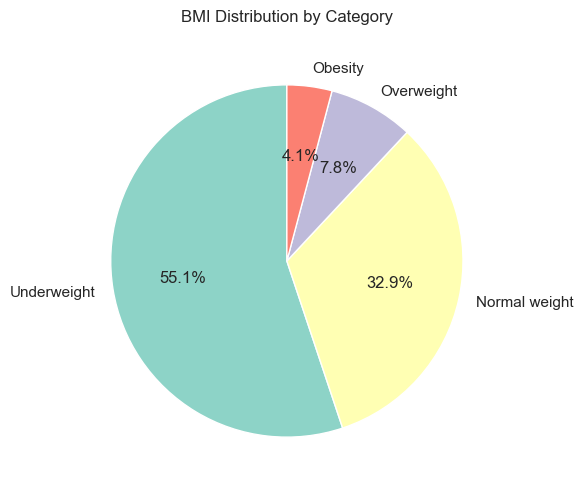

In [244]:
bmi_categories = [
    ('Underweight', train['Physical-BMI'] < 18.5),
    ('Normal weight', (train['Physical-BMI'] >= 18.5) & (train['Physical-BMI'] <= 24.9)),
    ('Overweight', (train['Physical-BMI'] >= 25) & (train['Physical-BMI'] <= 29.9)),
    ('Obesity', train['Physical-BMI'] >= 30)
]
bmi_category_counts = {label: condition.sum() for label, condition in bmi_categories}

plt.figure(figsize=(5, 6))
plt.pie(bmi_category_counts.values(),
        labels=bmi_category_counts.keys(),
        autopct='%1.1f%%', startangle=90,
        colors=plt.cm.Set3.colors)
plt.title('BMI Distribution by Category')
plt.axis('equal')
plt.show()

In [245]:
train[train['Physical-BMI'] < 12][cols + ['Basic_Demos-Age']].sort_values(by = 'Physical-BMI')

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Basic_Demos-Age
2848,8.523273,149.860,19.141582,NaN,68.0,77.0,106.0,8
1952,9.694718,149.860,21.772416,NaN,64.0,86.0,107.0,7
3463,9.960144,152.400,23.133192,NaN,48.0,73.0,97.0,6
3324,10.282698,147.320,22.316726,NaN,72.0,72.0,116.0,6
1707,10.676487,162.560,28.213422,NaN,99.0,90.0,134.0,7
3143,11.468414,131.318,19.776611,NaN,59.0,77.0,110.0,8
1700,11.676989,167.005,32.567906,NaN,50.0,90.0,106.0,10
3636,11.713943,139.700,22.861037,NaN,58.0,99.0,104.0,7
1307,11.750716,112.522,14.877818,48.26,NaN,77.0,NaN,7
156,11.916424,149.860,26.761928,71.12,76.0,83.0,118.0,11


In [246]:
train[train['Physical-Systolic_BP'] > 160][cols + ['Basic_Demos-Age']].sort_values(by = 'Physical-Systolic_BP')

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Basic_Demos-Age
1794,14.036968,121.920,20.865232,NaN,111.0,69.0,161.0,8
284,21.719865,152.527,50.530149,NaN,96.0,99.0,161.0,12
3032,14.272220,129.540,23.949658,NaN,104.0,89.0,161.0,9
2401,17.245599,129.540,28.939170,NaN,87.0,103.0,161.0,8
882,16.398111,124.460,25.401152,NaN,127.0,95.0,161.0,6
...,...,...,...,...,...,...,...,...
1019,14.172653,124.460,21.953853,60.96,107.0,113.0,194.0,8
2777,21.625191,134.620,39.190349,NaN,105.0,100.0,194.0,7
2549,23.154916,169.926,66.859461,NaN,74.0,69.0,197.0,17
436,27.260353,175.260,83.733083,NaN,108.0,69.0,198.0,19


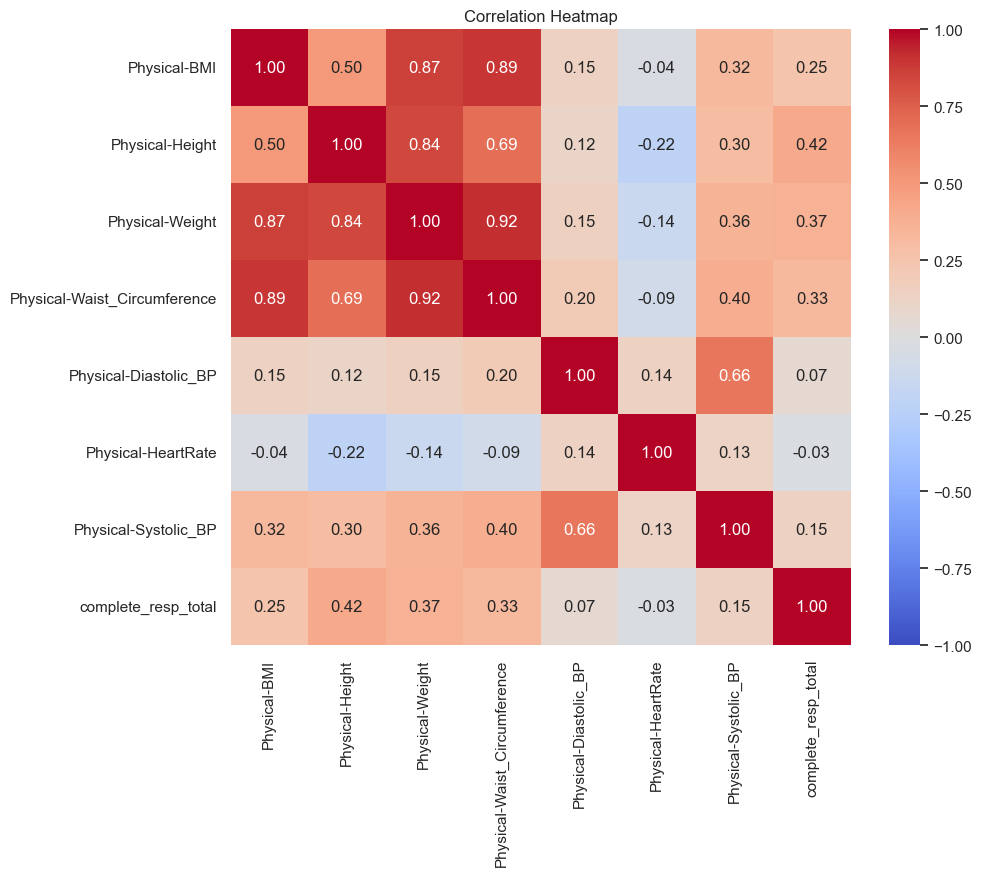

In [247]:
data_subset = train[cols + ['complete_resp_total']]

corr_matrix = data_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [248]:
data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']

,Instrument,Field,Description,Type,Values,Value Labels
33,Bio-electric Impedance Analysis,BIA-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
34,Bio-electric Impedance Analysis,BIA-BIA_Activity_Level_num,Activity Level,categorical int,"1,2,3,4,5","1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=..."
35,Bio-electric Impedance Analysis,BIA-BIA_BMC,Bone Mineral Content,float,NaN,NaN
36,Bio-electric Impedance Analysis,BIA-BIA_BMI,Body Mass Index,float,NaN,NaN
37,Bio-electric Impedance Analysis,BIA-BIA_BMR,Basal Metabolic Rate,float,NaN,NaN
38,Bio-electric Impedance Analysis,BIA-BIA_DEE,Daily Energy Expenditure,float,NaN,NaN
39,Bio-electric Impedance Analysis,BIA-BIA_ECW,Extracellular Water,float,NaN,NaN
40,Bio-electric Impedance Analysis,BIA-BIA_FFM,Fat Free Mass,float,NaN,NaN
41,Bio-electric Impedance Analysis,BIA-BIA_FFMI,Fat Free Mass Index,float,NaN,NaN
42,Bio-electric Impedance Analysis,BIA-BIA_FMI,Fat Mass Index,float,NaN,NaN


In [249]:
bia_data_dict = data_dict[data_dict['Instrument'] == 'Bio-electric Impedance Analysis']
categorical_columns = bia_data_dict[bia_data_dict['Type'] == 'categorical int']['Field'].tolist()
continuous_columns = bia_data_dict[bia_data_dict['Type'] == 'float']['Field'].tolist()

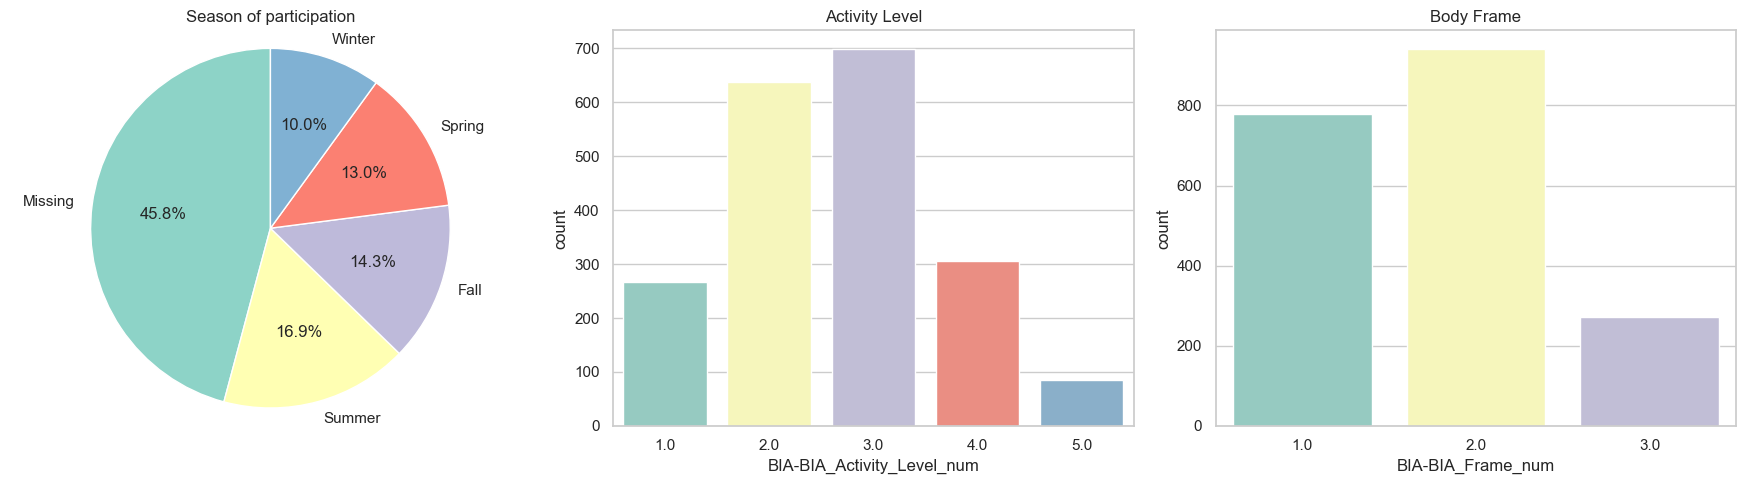

In [250]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Season
season_counts = train['BIA-Season'].value_counts(normalize=True)
axes[0].pie(
    season_counts, 
    labels=season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
axes[0].set_title(
    f"{bia_data_dict[bia_data_dict['Field'] == 'BIA-Season']['Description'].values[0]}"
)
axes[0].axis('equal')

# Other categorical columns
for idx, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=train, palette="Set3", ax=axes[idx+1])
    axes[idx+1].set_title(data_dict[data_dict['Field'] == col]['Description'].values[0])

plt.tight_layout()
plt.show()


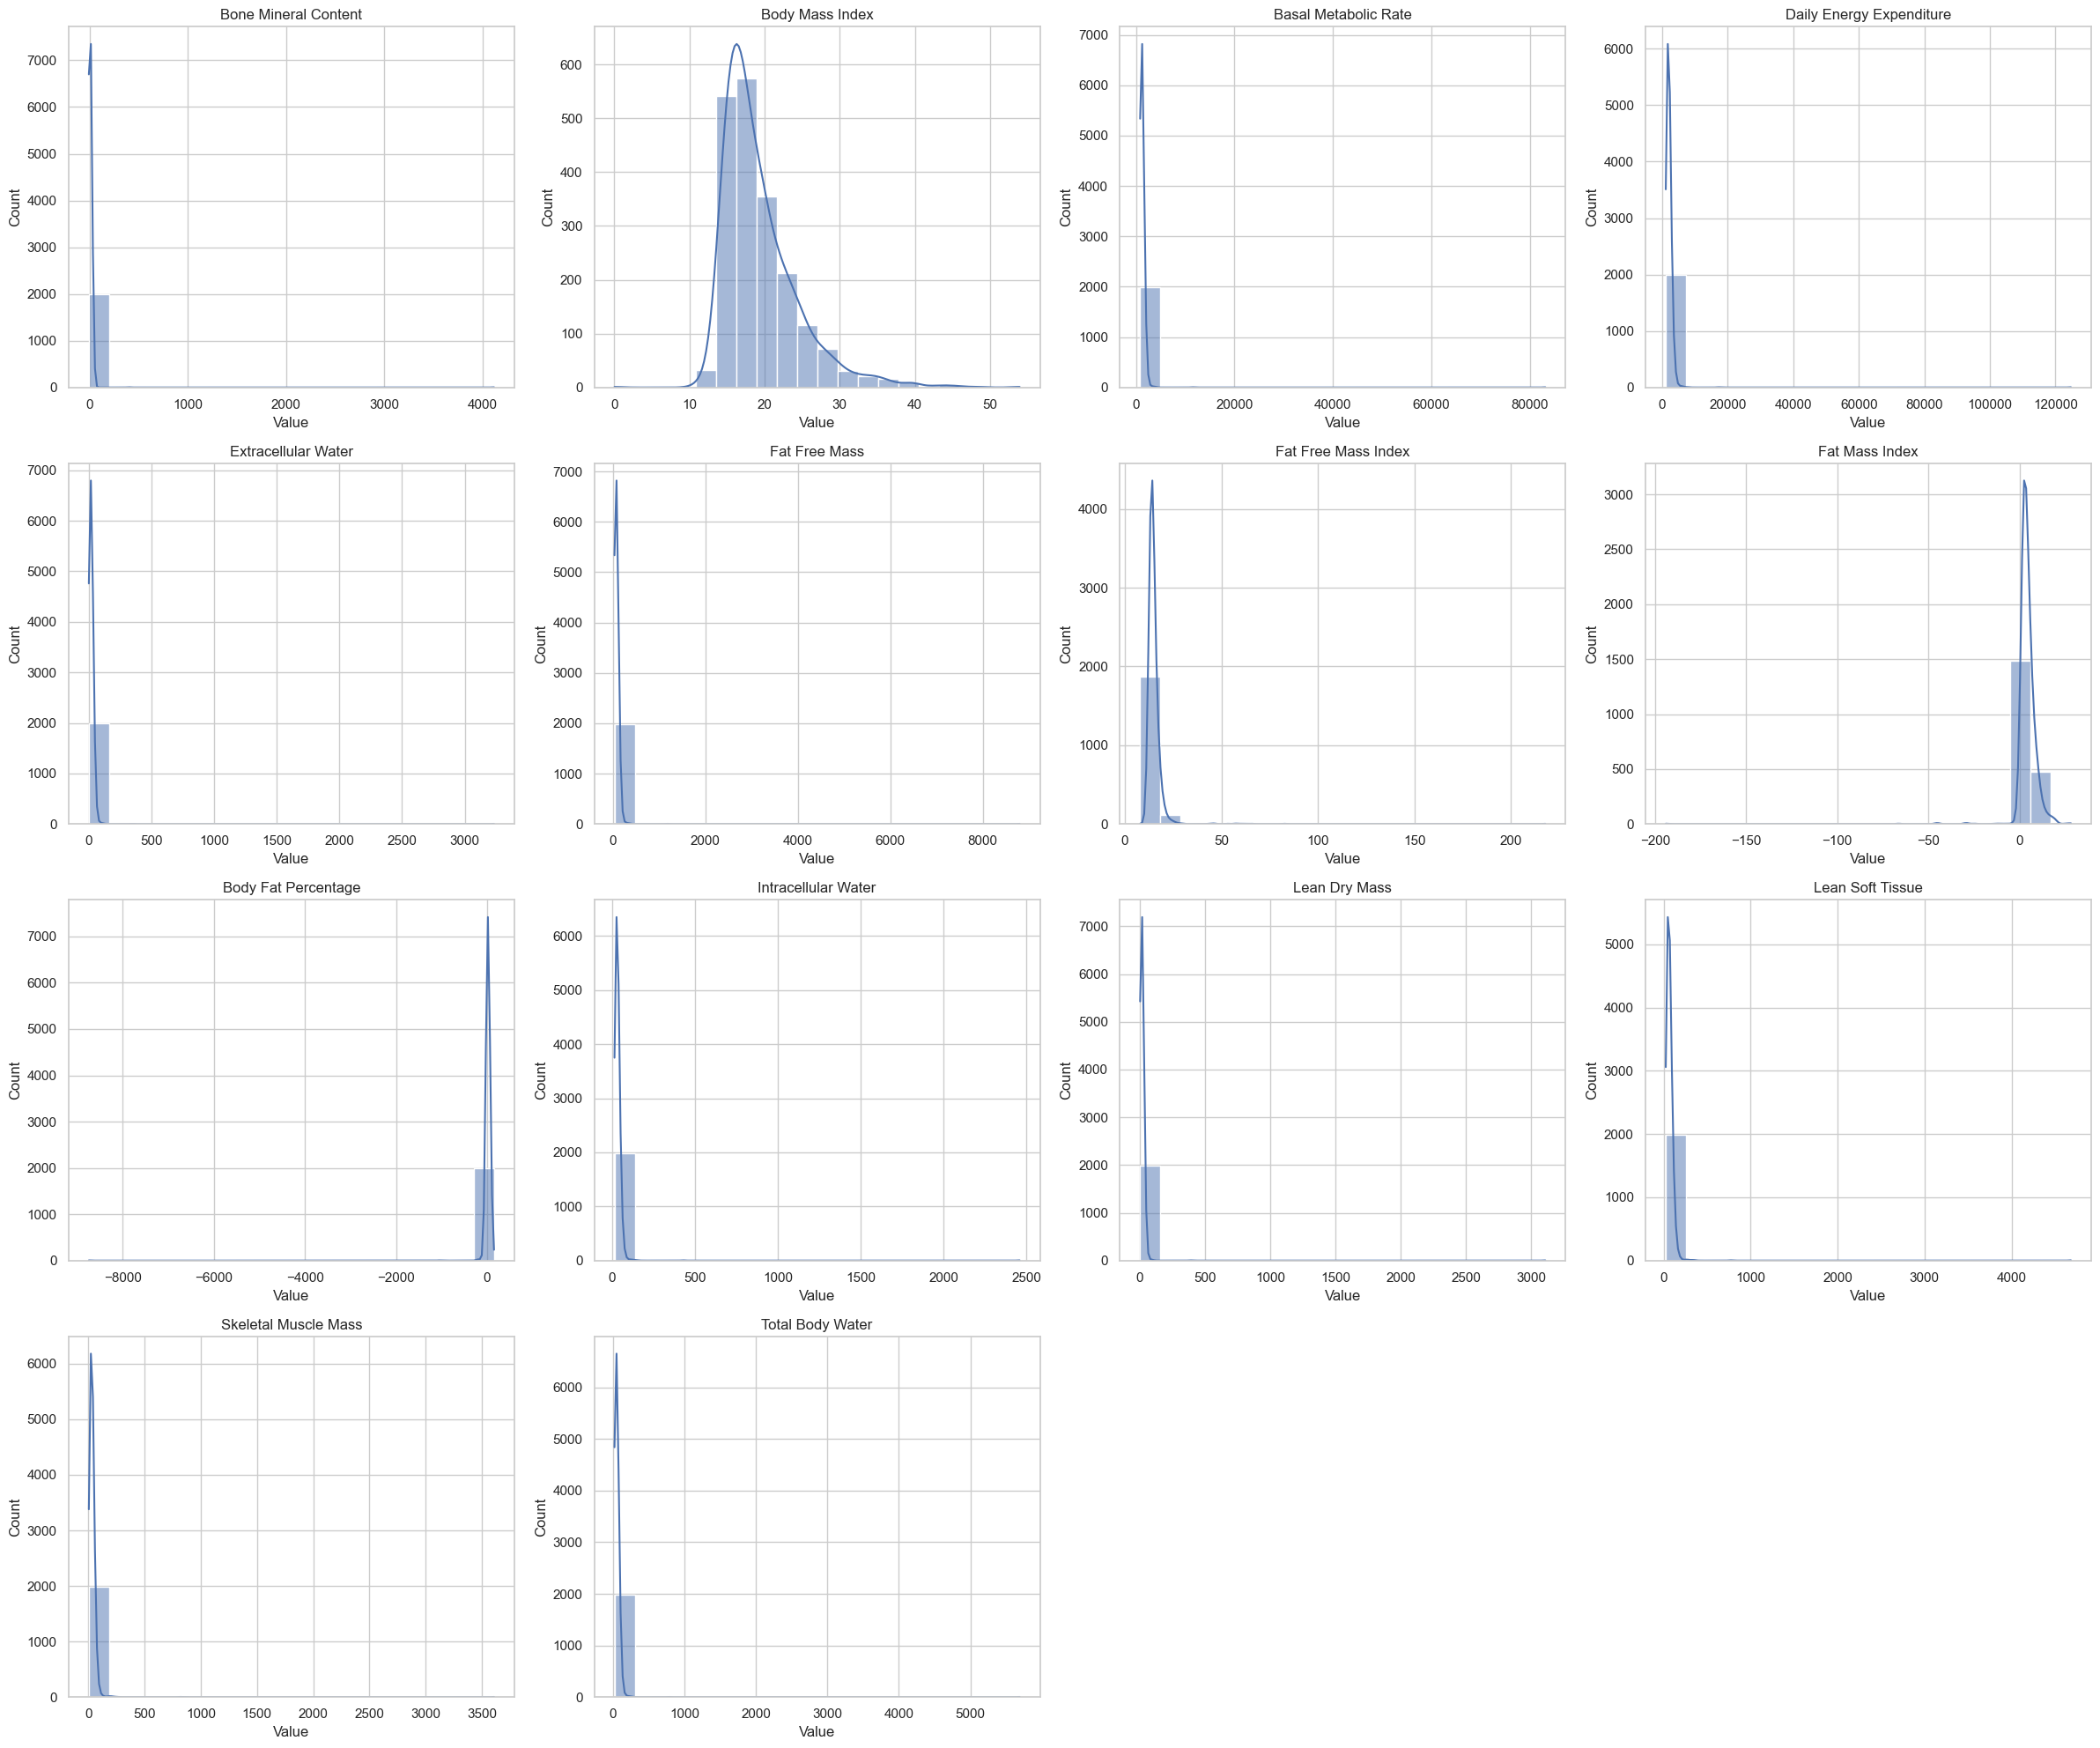

In [251]:
plt.figure(figsize=(24, 20))

for idx, col in enumerate(continuous_columns):
    plt.subplot(4, 4, idx + 1)
    sns.histplot(train[col].dropna(), bins=20, kde=True)
    plt.title(data_dict[data_dict['Field'] == col]['Description'].values[0])
    plt.xlabel('Value')

plt.tight_layout()
plt.show()

In [252]:
calculate_stats(train, continuous_columns)

,count,mean,std,min,25%,50%,75%,max,missing
BIA-BIA_BMC,1991.0,6.719826,92.586325,-7.789610,2.966905,3.92272,5.460925,4115.3600,1969
BIA-BIA_BMI,1991.0,19.367048,5.047848,0.048267,15.913600,17.96650,21.461100,53.9243,1969
BIA-BIA_BMR,1991.0,1237.018187,1872.383246,813.397000,1004.710000,1115.38000,1310.360000,83152.2000,1969
BIA-BIA_DEE,1991.0,2064.693747,2836.246272,1073.450000,1605.785000,1863.98000,2218.145000,124728.0000,1969
BIA-BIA_ECW,1991.0,20.825346,73.266287,1.789450,11.109550,15.92800,25.162200,3233.0000,1969
BIA-BIA_FFM,1991.0,74.021708,199.433753,28.900400,49.278100,61.06620,81.833800,8799.0800,1969
BIA-BIA_FFMI,1991.0,15.030554,5.792505,7.864850,13.408000,14.09250,15.430950,217.7710,1969
BIA-BIA_FMI,1991.0,4.336495,6.356402,-194.163000,2.306915,3.69863,5.987690,28.2515,1969
BIA-BIA_Fat,1991.0,16.855020,199.372119,-8745.080000,8.602395,16.17460,30.273100,153.8200,1969
BIA-BIA_ICW,1991.0,33.173380,56.272346,14.489000,24.463500,28.85580,35.475700,2457.9100,1969


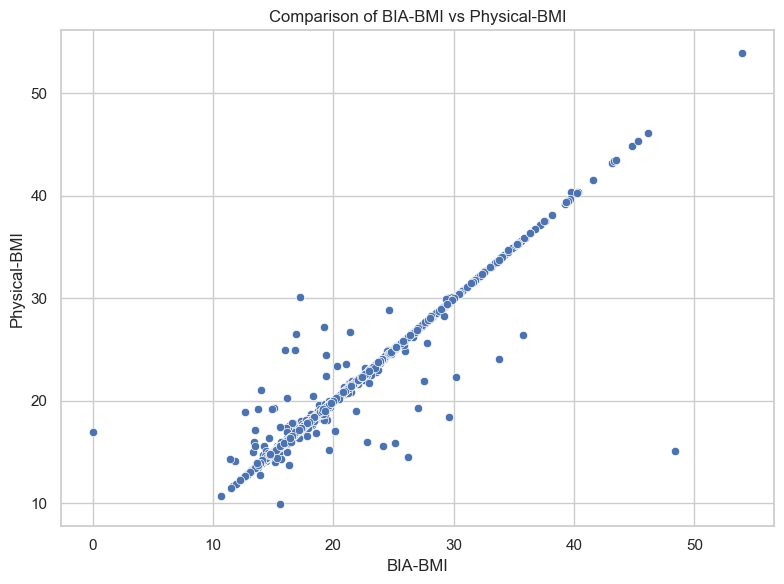

In [253]:
bmi_data = train[['BIA-BIA_BMI', 'Physical-BMI']].dropna()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='BIA-BIA_BMI', y='Physical-BMI',
    data=bmi_data,
    color='b'
)
plt.title('Comparison of BIA-BMI vs Physical-BMI')
plt.xlabel('BIA-BMI')
plt.ylabel('Physical-BMI')

plt.tight_layout()
plt.show()

In [254]:
bmi_measures = train[['BIA-Season', 'Physical-Season']].dropna()
bmi_measures.groupby(['BIA-Season', 'Physical-Season']).size().reset_index(name='Count')

,BIA-Season,Physical-Season,Count
0,Fall,Fall,407
1,Fall,Missing,6
2,Fall,Spring,15
3,Fall,Summer,131
4,Fall,Winter,8
5,Missing,Fall,294
6,Missing,Missing,635
7,Missing,Spring,309
8,Missing,Summer,277
9,Missing,Winter,300


In [255]:
groups.get('FitnessGram Vitals and Treadmill', [])

['Fitness_Endurance-Season',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec']

In [256]:
data = train[train['Fitness_Endurance-Max_Stage'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with Fitness_Endurance-Max_Stage data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with Fitness_Endurance-Max_Stage data: 6 - 12 years


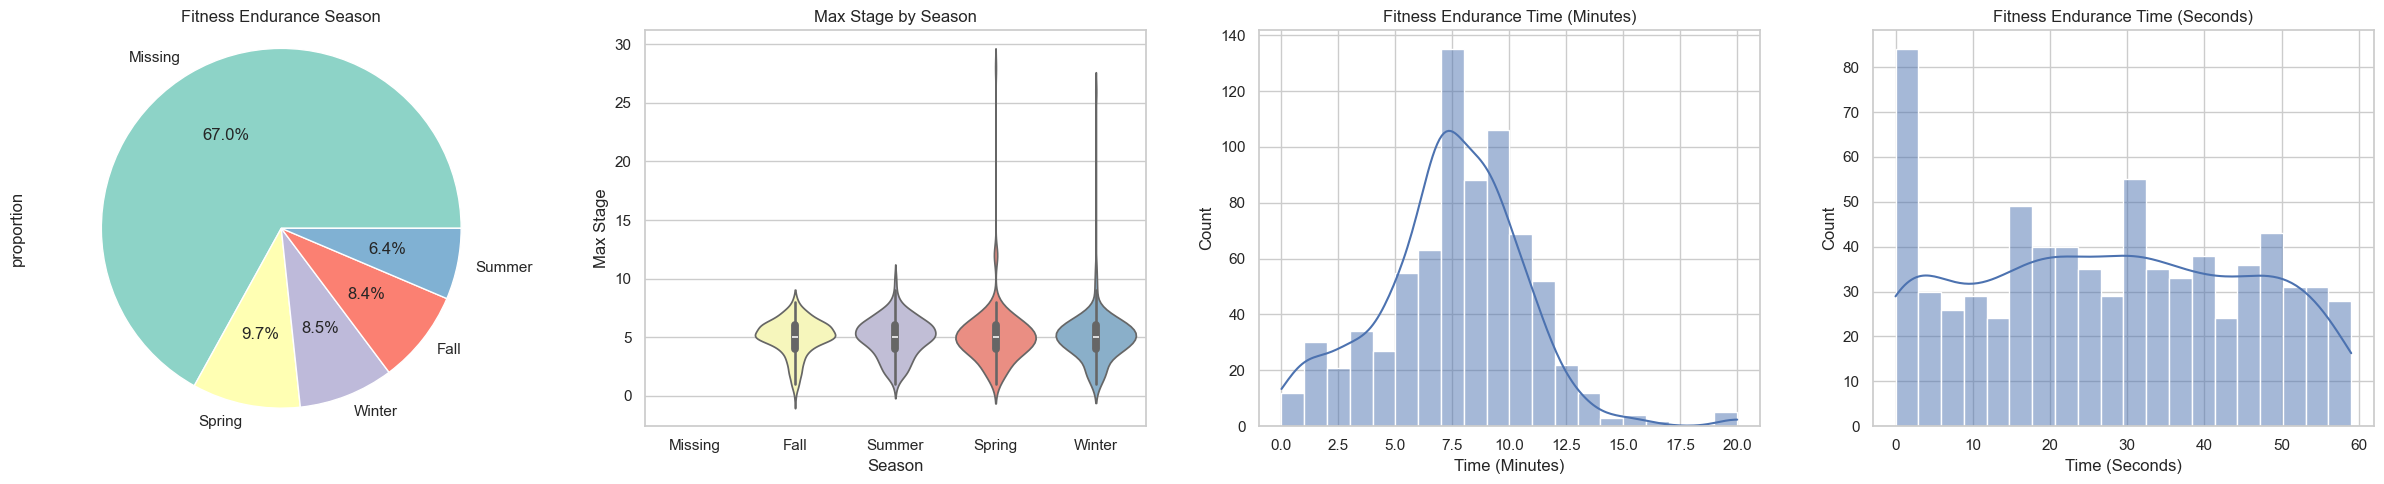

In [257]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Fitness Endurance Season
train['Fitness_Endurance-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors, ax=axes[0]
)
axes[0].set_title('Fitness Endurance Season')
axes[0].axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Box plot for Max Stage by Season
sns.violinplot(
    x='Fitness_Endurance-Season',
    y='Fitness_Endurance-Max_Stage',
    data=train, palette="Set3",
    ax=axes[1]
)
axes[1].set_title('Max Stage by Season')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Max Stage')

# Fitness Endurance Time (Minutes)
sns.histplot(train['Fitness_Endurance-Time_Mins'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Fitness Endurance Time (Minutes)')
axes[2].set_xlabel('Time (Minutes)')

# Fitness Endurance Time (Seconds)
sns.histplot(train['Fitness_Endurance-Time_Sec'], bins=20, kde=True, ax=axes[3])
axes[3].set_title('Fitness Endurance Time (Seconds)')
axes[3].set_xlabel('Time (Seconds)')

plt.tight_layout()
plt.show()

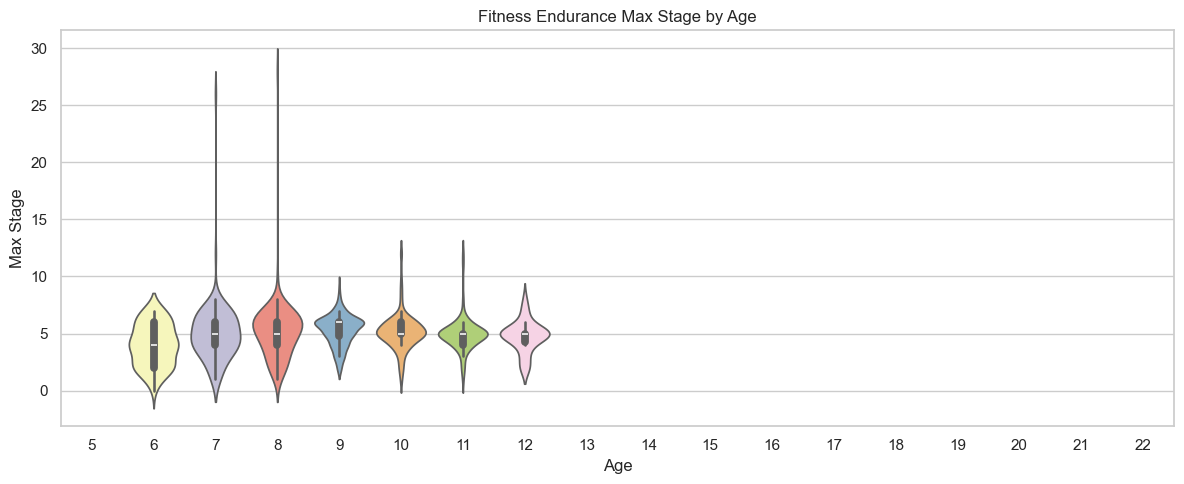

In [258]:
plt.figure(figsize=(12, 5))

sns.violinplot(x='Basic_Demos-Age', y='Fitness_Endurance-Max_Stage', data=train, palette="Set3")
plt.title('Fitness Endurance Max Stage by Age')
plt.xlabel('Age')
plt.ylabel('Max Stage')

plt.tight_layout()
plt.show()


In [259]:
cols = [
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec'
]
calculate_stats(train, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Fitness_Endurance-Max_Stage,743.0,4.989233,2.014072,0.0,4.00,5.0,6.0,28.0,3217
Fitness_Endurance-Time_Mins,740.0,7.370270,3.189662,0.0,6.00,7.0,9.0,20.0,3220
Fitness_Endurance-Time_Sec,740.0,27.581081,17.707751,0.0,12.75,28.0,43.0,59.0,3220


In [260]:
train[
    (train['Fitness_Endurance-Max_Stage'].notna()) & 
    (train['Fitness_Endurance-Time_Mins'].isna() | 
     train['Fitness_Endurance-Time_Sec'].isna())
][cols]

,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec
420,4.0,6.0,NaN
1470,26.0,NaN,NaN
2907,1.0,NaN,26.0
3666,2.0,NaN,NaN


In [261]:
train.loc[
    (train['Fitness_Endurance-Max_Stage'].notna()) & 
    (train['Fitness_Endurance-Time_Mins'].isna() | 
     train['Fitness_Endurance-Time_Sec'].isna()), cols
] = np.nan

In [262]:
train['Fitness_Endurance-Total_Time_Sec'] = train[
    'Fitness_Endurance-Time_Mins'
] * 60 + train['Fitness_Endurance-Time_Sec']

In [263]:
calculate_stats(train, ['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Total_Time_Sec'])

,count,mean,std,min,25%,50%,75%,max,missing
Fitness_Endurance-Max_Stage,739.0,4.971583,1.856069,0.0,4.0,5.0,6.0,28.0,3221
Fitness_Endurance-Total_Time_Sec,739.0,469.910690,188.716073,5.0,362.0,476.0,590.5,1200.0,3221


In [264]:
data_dict[data_dict['Instrument'] == 'FitnessGram Child']

,Instrument,Field,Description,Type,Values,Value Labels
18,FitnessGram Child,FGC-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
19,FitnessGram Child,FGC-FGC_CU,Curl up total,int,NaN,NaN
20,FitnessGram Child,FGC-FGC_CU_Zone,Curl up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
21,FitnessGram Child,FGC-FGC_GSND,Grip Strength total (non-dominant),float,NaN,NaN
22,FitnessGram Child,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
23,FitnessGram Child,FGC-FGC_GSD,Grip Strength total (dominant),float,NaN,NaN
24,FitnessGram Child,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
25,FitnessGram Child,FGC-FGC_PU,Push-up total,int,NaN,NaN
26,FitnessGram Child,FGC-FGC_PU_Zone,Push-up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
27,FitnessGram Child,FGC-FGC_SRL,Sit & Reach total (left side),float,NaN,NaN


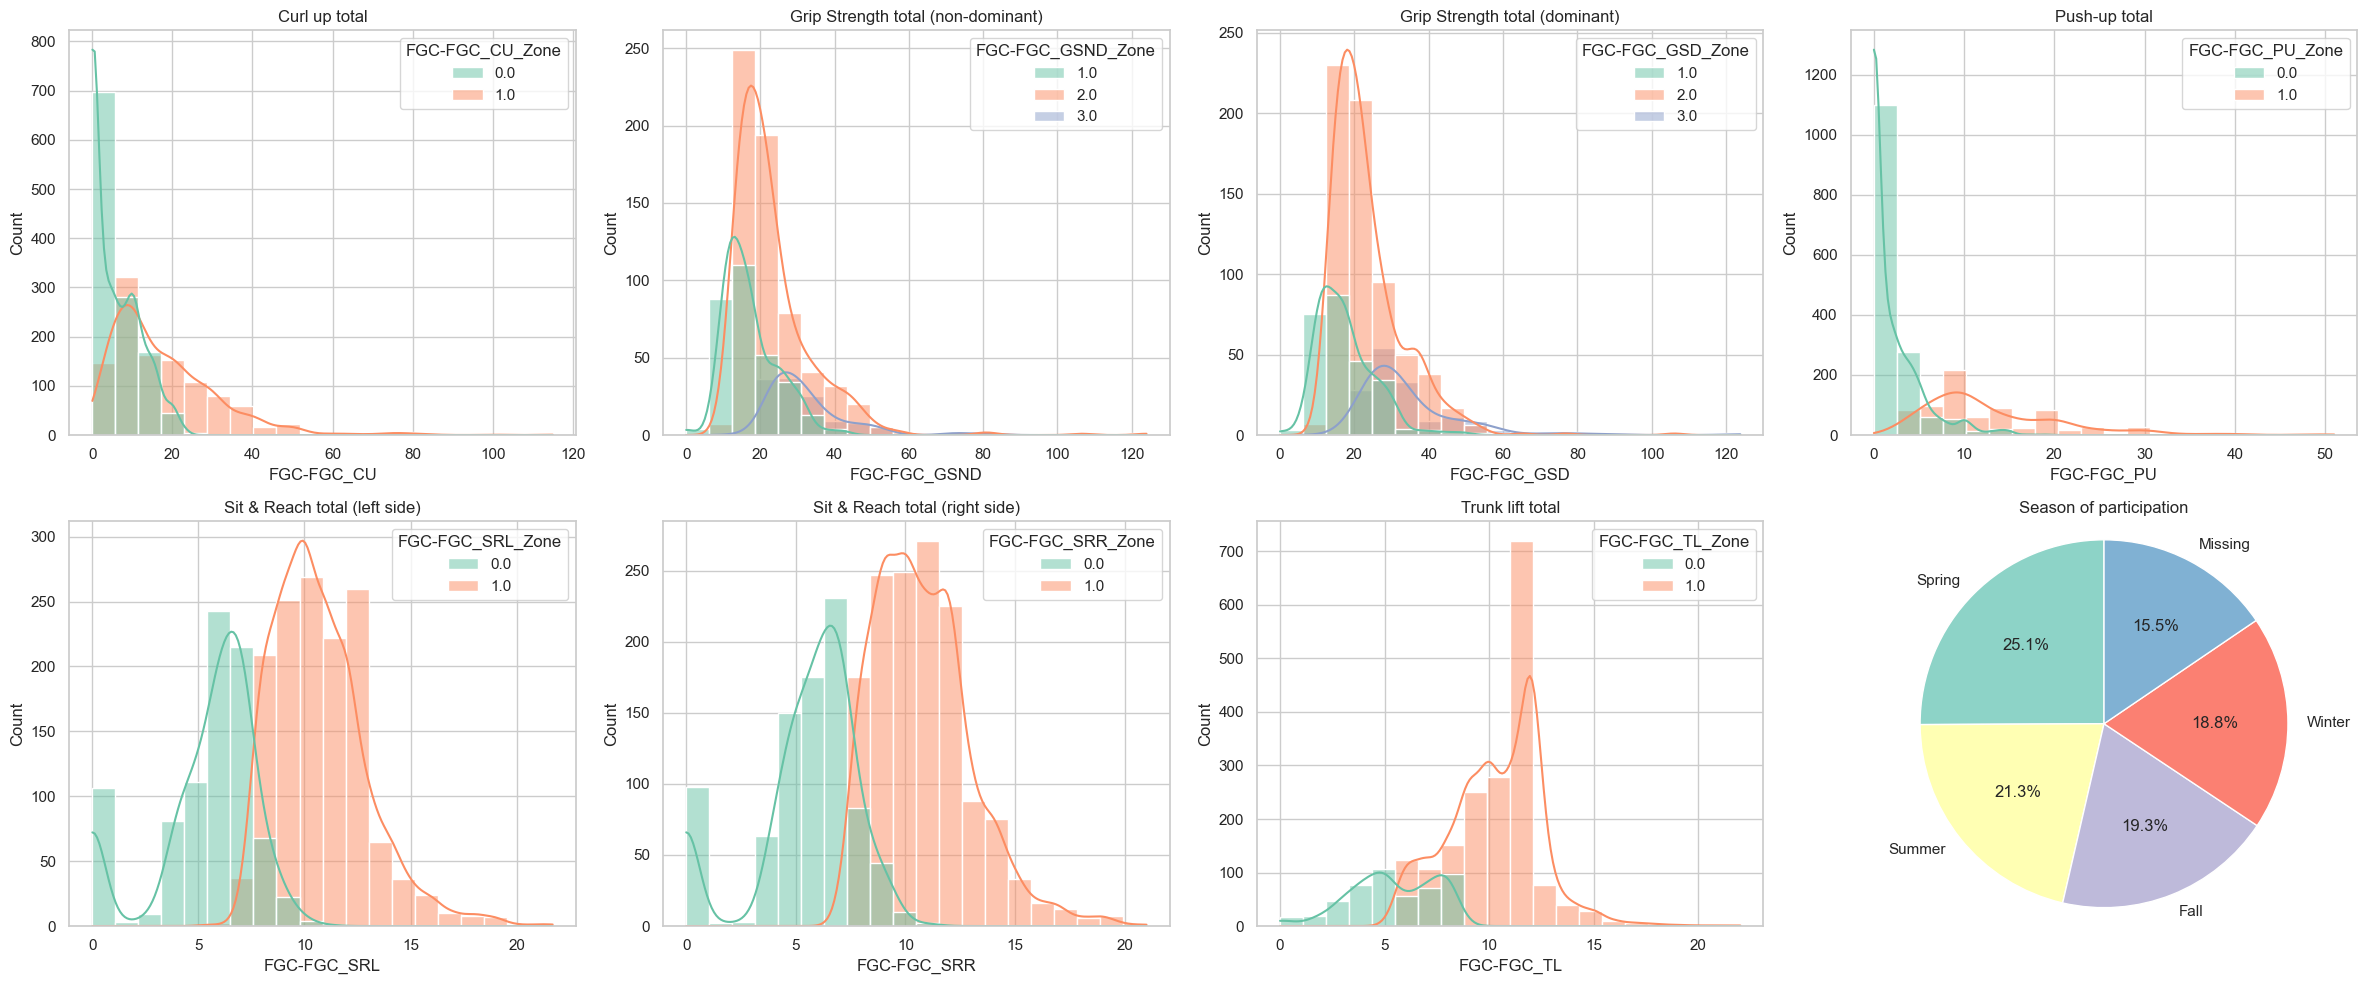

In [265]:
fgc_data_dict = data_dict[data_dict['Instrument'] == 'FitnessGram Child']

fgc_columns = []

for index, row in fgc_data_dict.iterrows():
    if '_Zone' not in row['Field']:
        measure_field = row['Field']
        measure_desc = row['Description']
        
        zone_field = measure_field + '_Zone'
        zone_row = fgc_data_dict[fgc_data_dict['Field'] == zone_field]
        
        if not zone_row.empty:
            zone_desc = zone_row['Description'].values[0]
            fgc_columns.append((measure_field, zone_field, measure_desc, zone_desc))
            
fig, axes = plt.subplots(2, 4, figsize=(24, 10))

for idx, (measure, zone, measure_desc, zone_desc) in enumerate(fgc_columns):
    row = idx // 4
    col = idx % 4
    
    sns.histplot(
        data=train, x=measure,
        hue=zone, bins=20, palette='Set2',
        ax=axes[row, col], kde=True
    )
    axes[row, col].set_title(f'{measure_desc}')

season_counts = train['FGC-Season'].value_counts(normalize=True)
axes[1, 3].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[1, 3].set_title('Season of participation')
axes[1, 3].axis('equal') 

plt.tight_layout()
plt.show()

In [266]:
measurement_columns = [measure for measure, _, _, _ in fgc_columns]
calculate_stats(train, measurement_columns)

,count,mean,std,min,25%,50%,75%,max,missing
FGC-FGC_CU,2322.0,11.259690,11.807781,0.0,3.0,9.00,15.750,115.0,1638
FGC-FGC_GSND,1074.0,22.420438,10.833995,0.0,15.1,20.05,26.600,124.0,2886
FGC-FGC_GSD,1074.0,23.518622,11.148951,0.0,16.2,21.20,28.175,123.8,2886
FGC-FGC_PU,2310.0,5.579654,7.390161,0.0,0.0,3.00,9.000,51.0,1650
FGC-FGC_SRL,2305.0,8.694924,3.429301,0.0,7.0,9.00,11.000,21.7,1655
FGC-FGC_SRR,2307.0,8.805635,3.422167,0.0,7.0,9.00,11.000,21.0,1653
FGC-FGC_TL,2324.0,9.252775,2.988863,0.0,7.0,10.00,12.000,22.0,1636


In [267]:
def compute_min_max_by_sex(train, sex, fgc_columns):
    results = []
    
    for measure, zone, _, _ in fgc_columns:
        sorted_zones = sorted(train[zone].dropna().unique())
        
        for zone_value in sorted_zones:
            data = train[(train[zone] == zone_value) & 
                         (train['Basic_Demos-Sex'] == sex)][measure]
            
            if not data.empty:
                min_val, max_val = data.min(), data.max()
                results.append({
                    'Zone': int(zone_value),
                    'Measure': measure,
                    'Min-Max': f'{min_val} - {max_val}'
                })
    
    df = pd.DataFrame(results).pivot_table(
        index='Zone', columns='Measure', values='Min-Max', aggfunc='first'
    )
    
    return df

In [268]:
compute_min_max_by_sex(train, 'Male', fgc_columns)

Measure,FGC-FGC_CU,FGC-FGC_GSD,FGC-FGC_GSND,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL
Zone,,,,,,,
0,0.0 - 23.0,NaN,NaN,0.0 - 19.0,0.0 - 7.75,0.0 - 8.0,0.0 - 8.2
1,2.0 - 85.0,0.0 - 46.8,0.0 - 43.0,3.0 - 51.0,7.5 - 20.0,7.0 - 19.0,5.5 - 21.0
2,NaN,12.7 - 106.0,12.6 - 106.4,NaN,NaN,NaN,NaN
3,NaN,22.5 - 123.8,22.6 - 81.8,NaN,NaN,NaN,NaN


In [269]:
compute_min_max_by_sex(train, 'Female', fgc_columns)

Measure,FGC-FGC_CU,FGC-FGC_GSD,FGC-FGC_GSND,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL
Zone,,,,,,,
0,0.0 - 17.0,NaN,NaN,0.0 - 6.0,0.0 - 11.0,0.0 - 11.0,0.0 - 8.5
1,2.0 - 115.0,5.1 - 49.8,0.0 - 36.2,3.0 - 50.0,5.5 - 21.7,8.5 - 21.0,5.5 - 22.0
2,NaN,9.5 - 65.2,9.0 - 124.0,NaN,NaN,NaN,NaN
3,NaN,16.3 - 88.8,15.5 - 74.0,NaN,NaN,NaN,NaN


In [270]:
results_male = []

for measure, zone, _, _ in fgc_columns:
    sorted_zones = sorted(train[zone].dropna().unique())
    for zone_value in sorted_zones:
        age_sex_data_by_zone = train[train[zone] == zone_value][
            ['Basic_Demos-Age', 'Basic_Demos-Sex', measure]
        ]
        unique_ages = age_sex_data_by_zone['Basic_Demos-Age'].dropna().unique()

        for age in sorted(unique_ages):
            age_sex_data = age_sex_data_by_zone[
                (age_sex_data_by_zone['Basic_Demos-Age'] == age) &
                (age_sex_data_by_zone['Basic_Demos-Sex'] == 'Male')
            ][measure]
            
            if not age_sex_data.empty:
                min_val, max_val = age_sex_data.min(), age_sex_data.max()
                results_male.append({
                    'Age': age,
                    'Sex': 'Male',
                    'Zone': zone_value,
                    'Measure': measure,
                    'Min-Max': f'{min_val} - {max_val}'
                })

df_male = pd.DataFrame(results_male).pivot_table(
    index=['Age', 'Sex', 'Zone'], columns='Measure', values='Min-Max', aggfunc='first'
)

df_male

Measure         FGC-FGC_CU   FGC-FGC_GSD  FGC-FGC_GSND   FGC-FGC_PU  \
Age Sex  Zone                                                         
5   Male 0.0     0.0 - 1.0           NaN           NaN    0.0 - 2.0   
         1.0    2.0 - 13.0           NaN           NaN    3.0 - 8.0   
6   Male 0.0     0.0 - 1.0           NaN           NaN    0.0 - 2.0   
         1.0    2.0 - 40.0           NaN           NaN   3.0 - 20.0   
7   Male 0.0     0.0 - 3.0           NaN           NaN    0.0 - 3.0   
         1.0    2.0 - 30.0           NaN           NaN   3.0 - 24.0   
8   Male 0.0     0.0 - 5.0           NaN           NaN    0.0 - 5.0   
         1.0    4.0 - 30.0           NaN           NaN   4.0 - 40.0   
9   Male 0.0    0.0 - 10.0           NaN           NaN    0.0 - 5.0   
         1.0    6.0 - 43.0   11.1 - 11.1           NaN   5.0 - 30.0   
         2.0           NaN   13.3 - 13.3   12.7 - 13.1          NaN   
10  Male 0.0    0.0 - 11.0           NaN           NaN    0.0 - 6.0   
         1.0    9.0 - 75.0    0.0 - 16.1    0.0 - 15.1   6.0 - 37.0   
         2.0           NaN   12.7 - 44.0   12.6 - 34.0          NaN   
         3.0           NaN   25.9 - 29.3   22.9 - 50.2          NaN   
11  Male 0.0    0.0 - 14.0           NaN           NaN    0.0 - 7.0   
         1.0   12.0 - 50.0    6.3 - 24.6    8.6 - 24.6   7.0 - 50.0   
         2.0           NaN   12.8 - 35.4   12.7 - 49.0          NaN   
         3.0           NaN   22.5 - 53.6   22.6 - 49.8          NaN   
12  Male 0.0    0.0 - 17.0           NaN           NaN    0.0 - 9.0   
         1.0   15.0 - 45.0    9.9 - 40.6    9.9 - 41.8   8.0 - 30.0   
         2.0           NaN   13.1 - 49.0   12.6 - 48.2          NaN   
         3.0           NaN   22.8 - 46.8   23.0 - 41.7          NaN   
13  Male 0.0    0.0 - 20.0           NaN           NaN   0.0 - 19.0   
         1.0   18.0 - 80.0   11.3 - 37.2    8.9 - 31.4  10.0 - 40.0   
         2.0           NaN   19.1 - 47.8   17.7 - 45.6          NaN   
         3.0           NaN   32.5 - 42.2   31.6 - 42.6          NaN   
14  Male 0.0    0.0 - 23.0           NaN           NaN   0.0 - 13.0   
         1.0   24.0 - 80.0   12.8 - 46.8   11.5 - 43.0  13.0 - 37.0   
         2.0           NaN   19.7 - 42.9   20.2 - 56.8          NaN   
         3.0           NaN   31.5 - 79.2   31.8 - 81.8          NaN   
15  Male 0.0    0.0 - 23.0           NaN           NaN   0.0 - 14.0   
         1.0   24.0 - 85.0    0.0 - 43.4    0.0 - 39.4  15.0 - 49.0   
         2.0           NaN   22.6 - 76.8   17.5 - 80.4          NaN   
         3.0           NaN   28.1 - 49.6   33.6 - 47.1          NaN   
16  Male 0.0    0.0 - 23.0           NaN           NaN   0.0 - 15.0   
         1.0   24.0 - 64.0   16.1 - 32.3   15.3 - 32.0  16.0 - 39.0   
         2.0           NaN   29.2 - 47.9   21.6 - 46.6          NaN   
         3.0           NaN   46.6 - 57.6   44.0 - 47.4          NaN   
17  Male 0.0    0.0 - 22.0           NaN           NaN   0.0 - 15.0   
         1.0   24.0 - 78.0   11.1 - 32.3   12.4 - 31.9  18.0 - 47.0   
         2.0           NaN  17.8 - 106.0  30.4 - 106.4          NaN   
         3.0           NaN  34.4 - 123.8   33.3 - 53.7          NaN   
18  Male 0.0    0.0 - 23.0           NaN           NaN   5.0 - 14.0   
         1.0   25.0 - 40.0           NaN   28.4 - 33.8  23.0 - 51.0   
         2.0           NaN   24.4 - 52.0   20.2 - 42.1          NaN   
         3.0           NaN   28.4 - 28.4   23.4 - 52.7          NaN   
19  Male 0.0    8.0 - 20.0           NaN           NaN    8.0 - 8.0   
         1.0           NaN   23.9 - 31.1   26.0 - 26.1  18.0 - 18.0   
20  Male 0.0           NaN           NaN           NaN  17.0 - 17.0   
         1.0   34.0 - 34.0           NaN           NaN          NaN   
         3.0           NaN   56.8 - 56.8   52.5 - 52.5          NaN   
21  Male 0.0   20.0 - 20.0           NaN           NaN  11.0 - 11.0   
         1.0   30.0 - 30.0           NaN   23.3 - 23.3  20.0 - 20.0   
         2.0           N

In [271]:
age_ranges = []

for measure in measurement_columns:
    valid_rows = train[~train[measure].isna()]
    
    min_age = valid_rows['Basic_Demos-Age'].min()
    max_age = valid_rows['Basic_Demos-Age'].max()
    
    age_ranges.append({
        'Measurement': measure,
        'Min Age': min_age,
        'Max Age': max_age
    })

age_ranges_df = pd.DataFrame(age_ranges)
age_ranges_df

,Measurement,Min Age,Max Age
0,FGC-FGC_CU,5,21
1,FGC-FGC_GSND,6,21
2,FGC-FGC_GSD,6,21
3,FGC-FGC_PU,5,21
4,FGC-FGC_SRL,5,21
5,FGC-FGC_SRR,5,21
6,FGC-FGC_TL,5,21


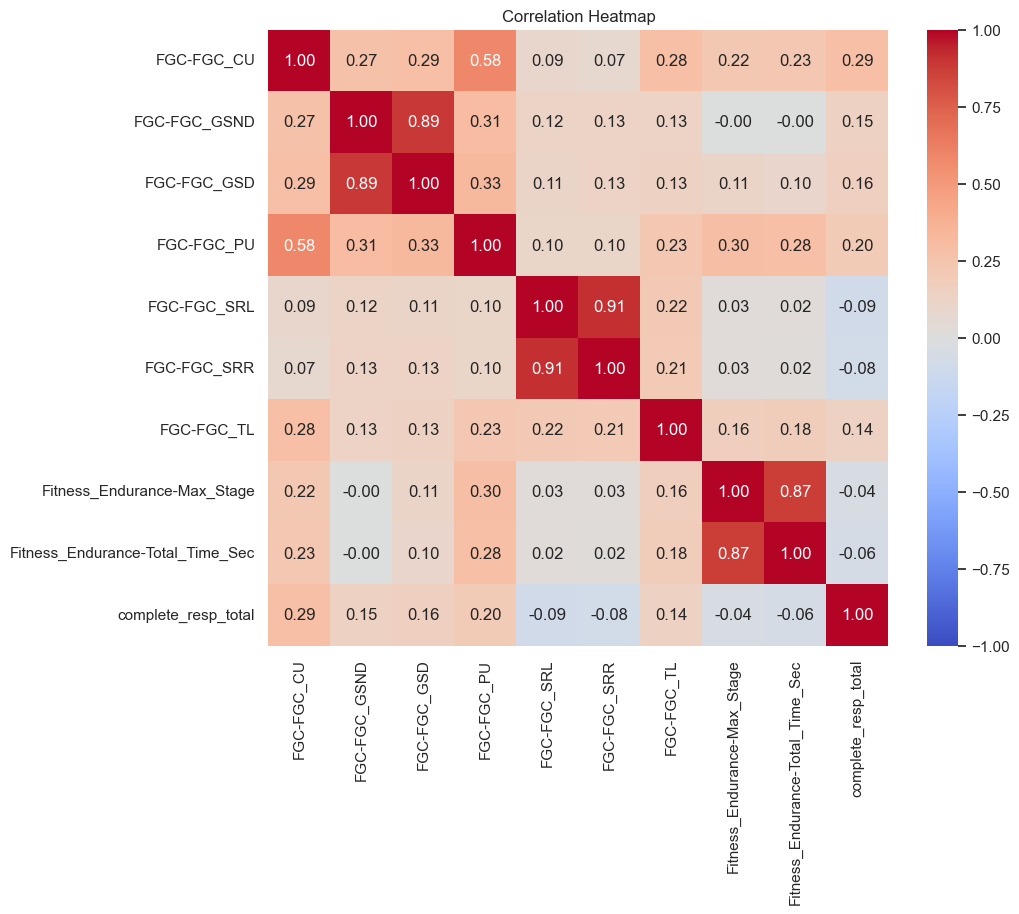

In [272]:
cols = [col for col in train.columns if col.startswith('FGC-') 
        and 'Zone' not in col and 'Season' not in col]
cols.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Total_Time_Sec'])

data_subset = train[cols + ['complete_resp_total']]

corr_matrix = data_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

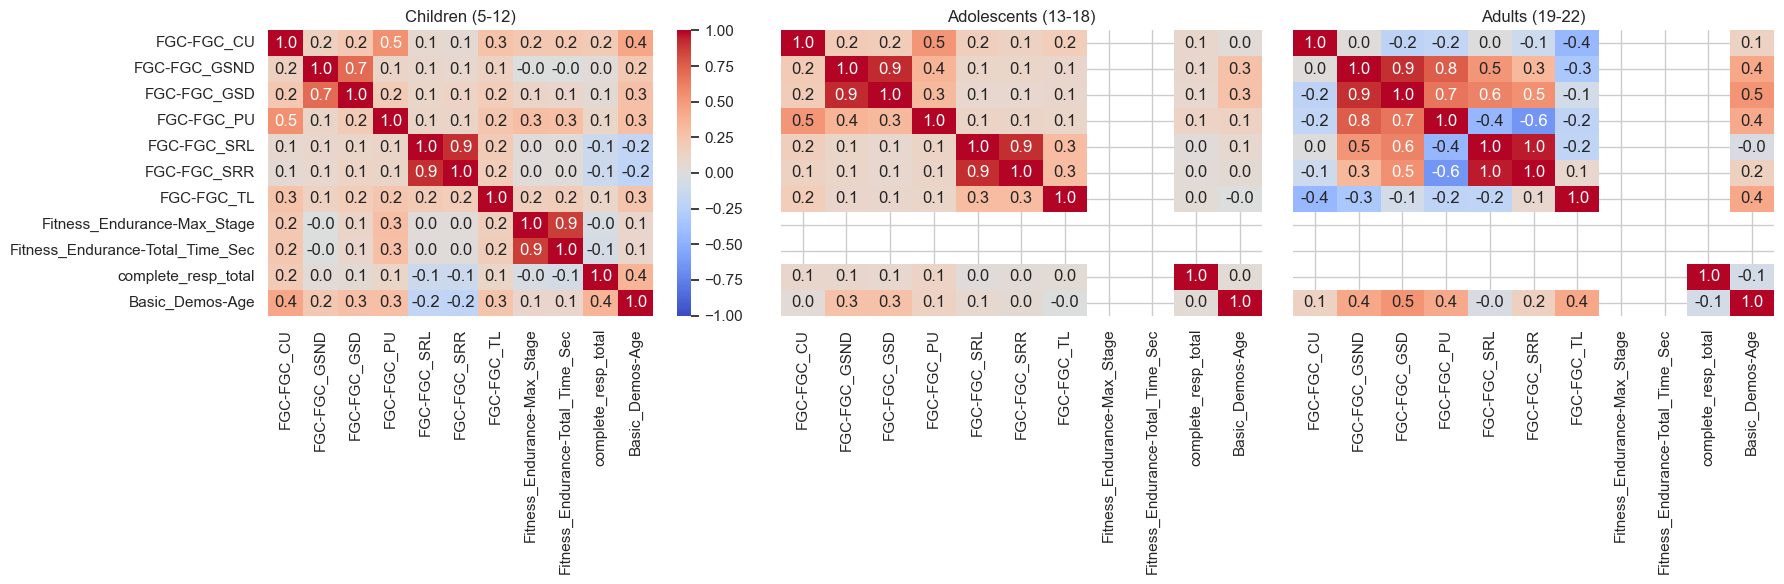

In [273]:
age_groups = train['Age Group'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, age_group in enumerate(age_groups):
    group_data = train[train['Age Group'] == age_group]
    corr_matrix = group_data[cols + ['complete_resp_total', 'Basic_Demos-Age']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f',
                vmin=-1, vmax=1, ax=axes[i], cbar=i == 0)
    axes[i].set_title(f'{age_group}')

plt.tight_layout()
plt.show()


In [274]:
groups.get('Sleep Disturbance Scale', [])

['SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']

In [275]:
data = train[train['SDS-SDS_Total_Raw'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for participants with SDS-SDS_Total_Raw data:"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for participants with SDS-SDS_Total_Raw data: 5 - 22 years


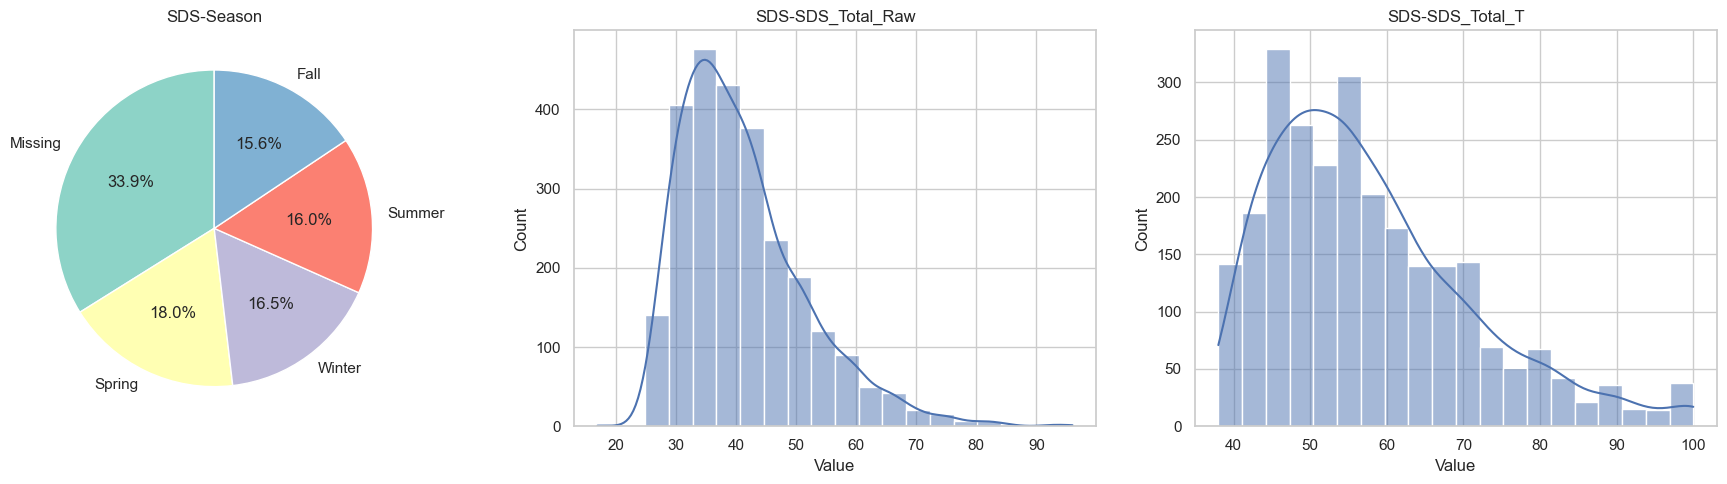

In [276]:
plt.figure(figsize=(18, 5))

# SDS-Season (Pie Chart)
plt.subplot(1, 3, 1)
sds_season_counts = train['SDS-Season'].value_counts(normalize=True)
plt.pie(
    sds_season_counts, 
    labels=sds_season_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette("Set3")
)
plt.title('SDS-Season')

# SDS-SDS_Total_Raw
plt.subplot(1, 3, 2)
sns.histplot(train['SDS-SDS_Total_Raw'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_Raw')
plt.xlabel('Value')

# SDS-SDS_Total_T
plt.subplot(1, 3, 3)
sns.histplot(train['SDS-SDS_Total_T'].dropna(), bins=20, kde=True)
plt.title('SDS-SDS_Total_T')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

In [277]:
calculate_stats(train, ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'])

,count,mean,std,min,25%,50%,75%,max,missing
SDS-SDS_Total_Raw,2609.0,41.088923,10.427433,17.0,33.0,39.0,46.0,96.0,1351
SDS-SDS_Total_T,2606.0,57.763622,13.196091,38.0,47.0,55.0,64.0,100.0,1354


In [278]:
groups.get('Physical Activity Questionnaire (Adolescents)', [])

['PAQ_A-Season', 'PAQ_A-PAQ_A_Total']

In [279]:
data = train[train['PAQ_A-PAQ_A_Total'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for Adolescents (with PAQ_A_Total data):"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for Adolescents (with PAQ_A_Total data): 13 - 18 years


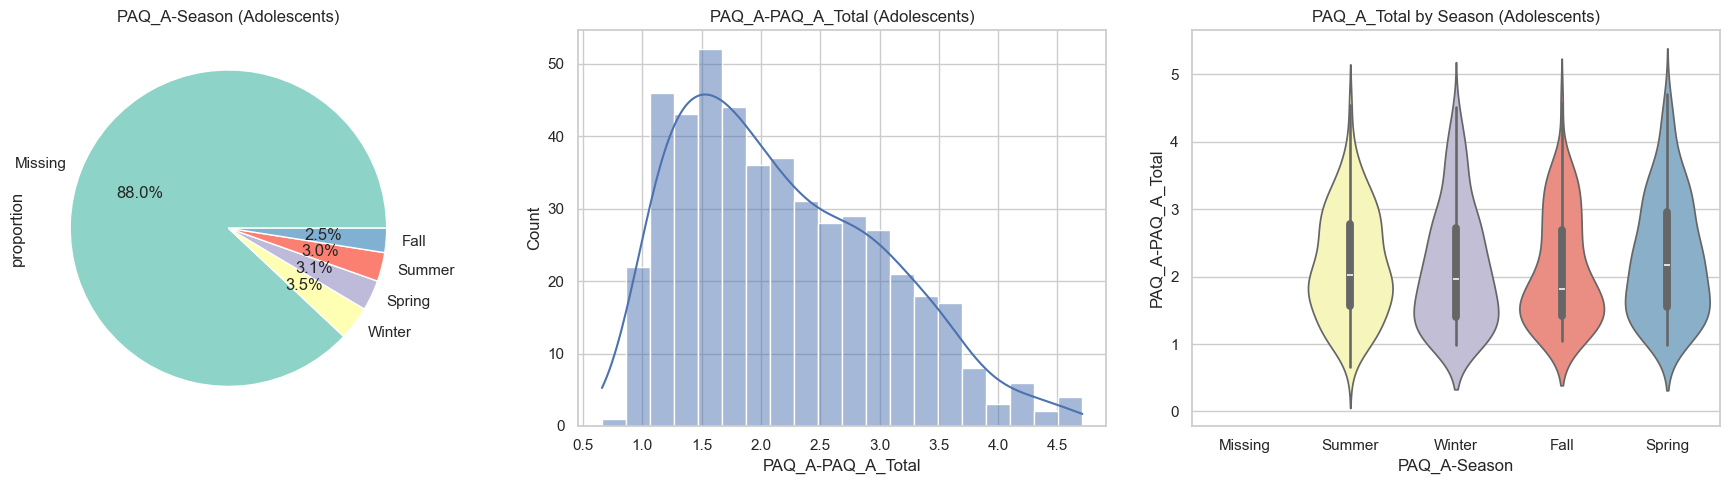

In [280]:
plt.figure(figsize=(18, 5))

# PAQ_A-Season
plt.subplot(1, 3, 1)
train['PAQ_A-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors
)
plt.title('PAQ_A-Season (Adolescents)')

# PAQ_A-PAQ_A_Total
plt.subplot(1, 3, 2)
sns.histplot(train['PAQ_A-PAQ_A_Total'], bins=20, kde=True)
plt.title('PAQ_A-PAQ_A_Total (Adolescents)')

# PAQ_A_Total by Season
plt.subplot(1, 3, 3)
sns.violinplot(x='PAQ_A-Season', y='PAQ_A-PAQ_A_Total', data=train, palette="Set3")
plt.title('PAQ_A_Total by Season (Adolescents)')

plt.tight_layout()
plt.show()


In [281]:
calculate_stats(train, ['PAQ_A-PAQ_A_Total'])

,count,mean,std,min,25%,50%,75%,max,missing
PAQ_A-PAQ_A_Total,,,,,,,,,
PAQ_A-PAQ_A_Total,475.0,2.178853,0.849476,0.66,1.49,2.01,2.78,4.71,3485


In [282]:
groups.get('Physical Activity Questionnaire (Children)', [])

['PAQ_C-Season', 'PAQ_C-PAQ_C_Total']

In [283]:
data = train[train['PAQ_C-PAQ_C_Total'].notnull()]
age_range = data['Basic_Demos-Age']
print(
    f"Age range for Children (with PAQ_C_Total data):"
    f" {age_range.min()} - {age_range.max()} years"
)

Age range for Children (with PAQ_C_Total data): 7 - 17 years


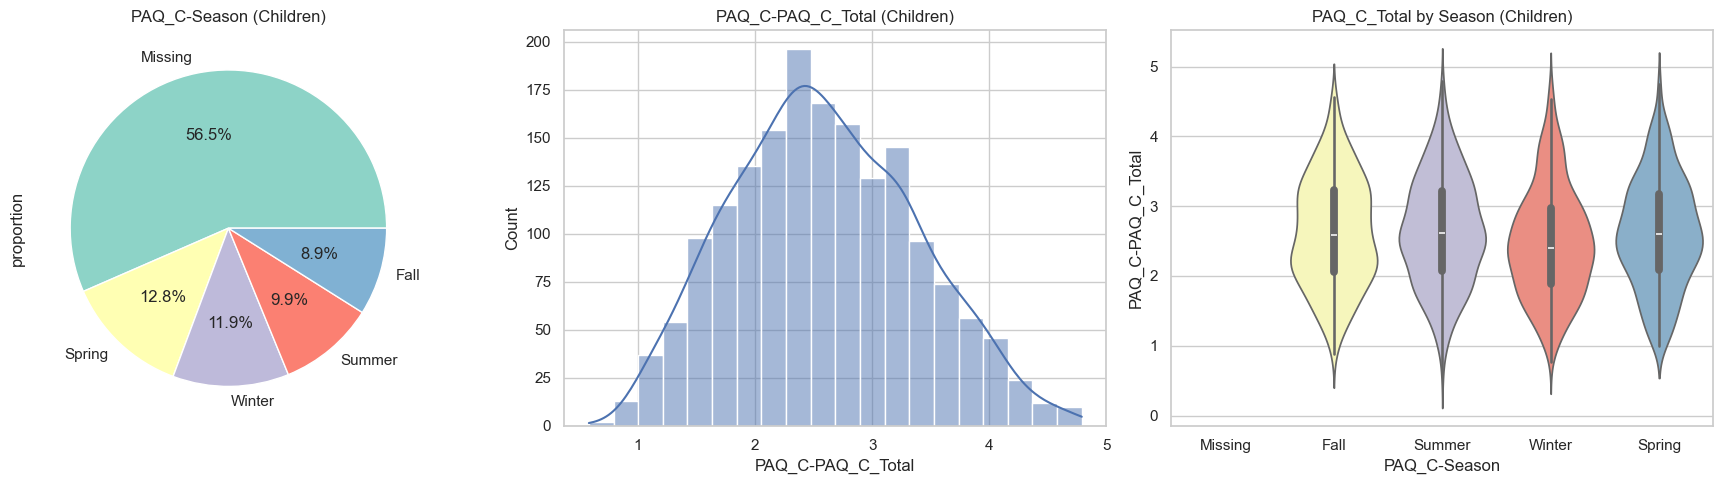

In [284]:
plt.figure(figsize=(18, 5))

# PAQ_C-Season
plt.subplot(1, 3, 1)
train['PAQ_C-Season'].value_counts(normalize=True).plot.pie(
    autopct='%1.1f%%', colors=plt.cm.Set3.colors
)
plt.title('PAQ_C-Season (Children)')

# PAQ_C-PAQ_C_Total
plt.subplot(1, 3, 2)
sns.histplot(train['PAQ_C-PAQ_C_Total'], bins=20, kde=True)
plt.title('PAQ_C-PAQ_C_Total (Children)')

# PAQ_C_Total by Season
plt.subplot(1, 3, 3)
sns.violinplot(x='PAQ_C-Season', y='PAQ_C-PAQ_C_Total', data=train, palette="Set3")
plt.title('PAQ_C_Total by Season (Children)')

plt.tight_layout()
plt.show()

In [285]:
calculate_stats(train, ['PAQ_C-PAQ_C_Total'])

,count,mean,std,min,25%,50%,75%,max,missing
PAQ_C-PAQ_C_Total,,,,,,,,,
PAQ_C-PAQ_C_Total,1721.0,2.58955,0.783937,0.58,2.02,2.54,3.16,4.79,2239


In [286]:
paq_columns = [col for col in train.columns if 'PAQ' in col]
train[(train['PAQ_A-PAQ_A_Total'].notnull()) &
      (train['PAQ_C-PAQ_C_Total'].notnull())][
    paq_columns + ['Basic_Demos-Age']
]

,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,Basic_Demos-Age
3331,Summer,2.27,Spring,2.32,13


In [287]:
data.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,complete_resp_total,Age Group,internet_use_encoded,CGAS_Score_Bin,Fitness_Endurance-Total_Time_Sec
1,000fd460,Summer,9,Male,Missing,NaN,Fall,14.036968,121.92,20.865232,55.88,75.0,70.0,122.0,Missing,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.9740,39.4497,15.4107,27.0552,Missing,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0 (None),0.0,Children (5-12),< 1h/day,NaN,NaN
2,00105258,Summer,10,Female,Fall,71.0,Fall,16.650330,143.51,34.291555,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,Missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,NaN,Summer,2.170,Fall,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0 (None),28.0,Children (5-12),~ 2hs/day,71-80: No more than slight impairment in funct...,453.0
3,00115b9f,Winter,9,Male,Fall,71.0,Summer,18.294143,142.24,37.013107,NaN,60.0,97.0,117.0,Summer,6.0,9.0,37.0,Summer,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,Summer,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.7790,58.9338,26.4798,45.9966,Missing,NaN,Winter,2.451,Summer,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,3.0,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1 (Mild),44.0,Children (5-12),< 1h/day,71-80: No more than slight impairment in funct...,577.0
5,001f3379,Spring,13,Female,Winter,50.0,Summer,22.282139,151.13,50.893022,NaN,60.0,73.0,102.0,Missing,NaN,NaN,NaN,Summer,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,Summer,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.9020,79.6982,35.3804,63.1265,Missing,NaN,Spring,4.110,Summer,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,1.0,0.0,1.0,3.0,3.0,2.0,1.0,3.0,1.0,2.0,1.0,34.0,Summer,40.0,56.0,Spring,0.0,1 (Mild),34.0,Adolescents (13-18),< 1h/day,41-50: Moderate degree of interference in func...,NaN
6,0038ba98,Fall,10,Male,Missing,NaN,Fall,19.662690,139.70,38.373883,NaN,123.0,83.0,163.0,Missing,NaN,NaN,NaN,Fall,9.0,1.0,NaN,NaN,NaN,NaN,2.0,0.0,11.0,1.0,11.0,1.0,11.0,1.0,Fall,2.0,3.78271,19.6629,1135.860,1817.38,16.32750,63.2470,14.7000,4.96291,21.35300,2.0,30.8936,16.0259,59.4643,26.1957,47.2211,Missing,NaN,Winter,3.670,Winter,1.0,4.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,0.0,20.0,Winter,27.0,40.0,Fall,3.0,0 (None),20.0,Children (5-12),> 3hs/day,NaN,NaN
